<h1 style="font-size:3vw"> Analysis and forecast of institutional investors' positions </h1>
<h1> Signal Purification </h1>

<div style="text-align: right"><q><i> Was it Mr Big, was it New York or was it me? </i></q></div>
<div style="text-align: right"> Carrie Bradshaw </div>

Программный код и размышления, используемые для написания курсовой работы.

# Импорт библиотек и загрузка данных

Импортирую библиотеки для обработки данных.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns
import ipython_memory_usage

import warnings
warnings.filterwarnings("ignore")

%ipython_memory_usage_start

'memory profile enabled'

In [9] used -1901.4922 MiB RAM in 0.16s, peaked 0.00 MiB above current, total RAM usage 29.79 MiB


Считывание файла с данными. Он очень большой!

In [10]:
%%time
df = pd.read_csv(r'C:\Users\Redmi\Downloads\f13_data.csv')

Wall time: 1min 39s
In [10] used 1916.9609 MiB RAM in 99.90s, peaked 1921.27 MiB above current, total RAM usage 1946.75 MiB


В этом датасете много разных столбцов. Некоторые я до сих пор не понимаю.

In [3]:
df.columns

Index(['Unnamed: 0', 'stamp', 'access_id', 'other_manager',
       'investment_discretion', 'put_call', 'security_class',
       'ssh_prn_amt_type', 'acceptance_stamp', 'market_value', 'ssh_prn_amt',
       'voting_authority_sole', 'voting_authority_shared',
       'voting_authority_none', 'cik', 'conformed_submission_type',
       'conformed_period_of_report', 'filed_as_of_date', 'date_of_change',
       'effectiveness_date', 'fiscal_year_end', 'close', 'is_shifted_price',
       'id'],
      dtype='object')

Подгрузим таблицу соответствия CIK и наименования институционального инвестора. Таблица соответствия взята из базы <a href="https://www.sec.gov/Archives/edgar/cik-lookup-data.txt">EDGAR</a>.

In [4]:
cik_array = []

# Открываю файл
with open('cik-lookup-data.txt', 'r') as cik_data:
    
    # Создаю массив из пар "CIK - Название компании"
    for string in cik_data:
        if string:
            cik_array.append([string[:-13], int(string[-12:-2])])

# Перевожу массив в Dataframe
cik_lookup = pd.DataFrame(data=cik_array, columns=['fund_name', 'cik'])
cik_lookup.head()

,fund_name,cik
0,!J INC,1438823
1,"#1 A LIFESAFER HOLDINGS, INC.",1509607
2,#1 ARIZONA DISCOUNT PROPERTIES LLC,1457512
3,#1 PAINTBALL CORP,1433777
4,$ LLC,1427189


Теперь подгрузим таблицу соответствия тикера и его id. Таблица соответствия взята из базы <a href="https://www.sec.gov/include/ticker.txt">EDGAR</a>. С их помощью я через Yahoo! Finance я попытаюсь вычленить сектор каждой компании-эмитента, чтобы на его основе сгенерировать полезные для анализа переменные.

In [5]:
# Считываю таблицу соответствия
tickers_lookup = pd.read_csv('ticker.txt', sep='\t', names=['ticker', 'ticker_id'])
tickers_lookup.head()

,ticker,ticker_id
0,aapl,320193
1,msft,789019
2,amzn,1018724
3,goog,1652044
4,fb,1326801


Чтобы скачивать данные о секторе, я напишу специальную функцию.

In [6]:
# функция выгрузки секторов для набора тикеров
def extract_tickers_with_sector(symbols: list) -> pd.DataFrame :
    
    from yahooquery import Ticker
    
    # Получаю информацию из базы данных о тикерах
    tickers = Ticker(symbols, asynchronous=True)
    tickers = tickers.get_modules("summaryProfile quoteType")
    tickers = pd.DataFrame.from_dict(tickers).T
    
    # Преобразую информацию в понятный формат
    ticker_frames = [pd.json_normalize([x for x in tickers[module] if isinstance(x, dict)]) \
                                         for module in ['summaryProfile', 'quoteType']]
    
    # Оставляю необходимые столбцы
    tickers = pd.concat(ticker_frames, axis=1)[['symbol', 'sector']]
    # Для будущей пользы (и соответствия исходному формату) изменяю формат тикеров
    tickers.symbol = tickers.symbol.str.lower()

    return tickers

Теперь получу информацию о секторе.

In [10]:
%%time

# Формирую названия тикеров для функции
symbols = tickers_lookup.ticker.unique()
# Получаю значения секторов
tickers = extract_tickers_with_sector(symbols)
# Присоединяю данные о секторе к основной таблице
tickers = tickers.merge(tickers_lookup, left_on='symbol',
                        right_on='ticker', how='right', suffixes=(None, None))
# Удаляю ненужный столбец, по которому велось присоединение
tickers.drop('symbol', axis=1, inplace=True)

tickers.head()

Wall time: 7min 59s


,sector,ticker,ticker_id
0,Technology,aapl,320193
1,Technology,msft,789019
2,Consumer Cyclical,amzn,1018724
3,Communication Services,goog,1652044
4,Communication Services,fb,1326801


Я также заметил, что последняя буква (иногда и две) в написании тикеров часто соответствует типу финансового инструмента. Поэтому для тикеров с ненайденными секторами повторю процедуру, используя их в запросе без первой и второй буквы.

In [11]:
%%time

# Прохожу цикл по количеству убранных с конца букв
for last in (1, 2):
    # Составляю список правильных наименований тикеров без сектора для запроса
    symbols_without_sector = tickers[tickers.sector.isna()].ticker.str[:-last]
    # Получаю таблицу соответствия измененных названий тикеров и сектора
    res_for_symbols_without_sector = extract_tickers_with_sector(symbols_without_sector)
    # Составляю таблицу полных названий тикеров без названия и сектора
    sector_vals = symbols_without_sector.to_frame().merge(res_for_symbols_without_sector, how='left',
                                                          left_on='ticker', right_on='symbol').sector
    # Обновляю изначальную таблицу новыми соответствиями
    tickers.loc[tickers.sector.isna(), 'sector'] = sector_vals.values

# Изменяю пустые поля и отсутствия сектора на неопределенное значение
tickers['sector'] = tickers.sector.replace('', 'Undefined')
tickers['sector'] = tickers.sector.fillna('Undefined')
# Расширяю тип колонки идентификатора тикера для удобства сочленения с основными данными
tickers['ticker_id'] = tickers.ticker_id.astype('int64')

Wall time: 2min 29s


Посмотрим теперь на распределение секторов среди тикеров.

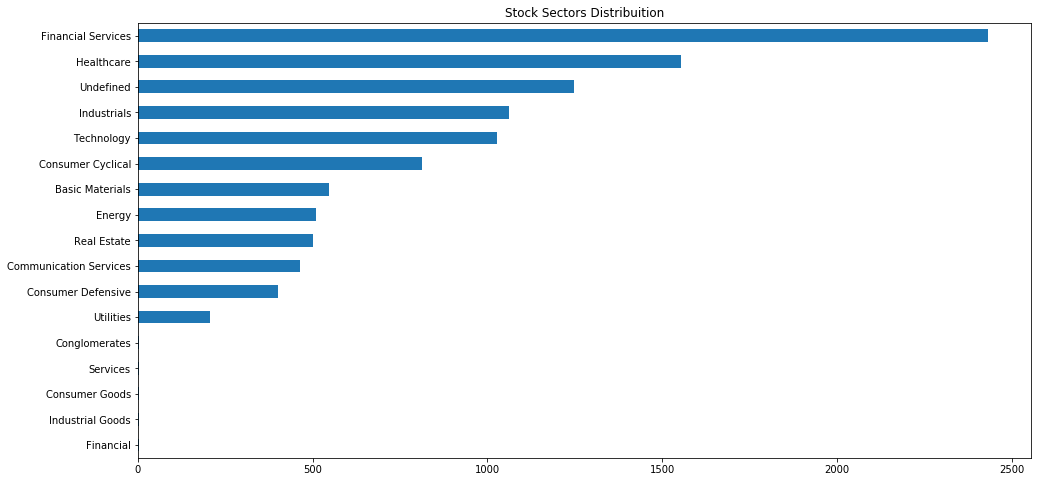

In [12]:
pl.figure(figsize=(16,8));
tickers.sector.value_counts().plot(kind='barh', title='Stock Sectors Distribuition').invert_yaxis();

Большинство компаний работают в секторах Здравоохранения и Финансовых услуг, а также в промышленности, IT и циклических индустрий. Замечу, что у нас огромная доля компаний не получила в соответствие сектор, что не очень приятно для дальнейшего анализа.

# Обработка датасета

Определяю количество лагов доли акции.

In [11]:
num_lags = 4

MAX_FILING = pow(10,13)
MAX_SSH_PRN_AMP = pow(10, 8)
MAX_MVAL = pow(10, 10)

In [11] used 7.6680 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 1954.42 MiB


Чищу данные.

In [12]:
%%time
# оставляю только акции
df = df[df['security_class'] == "STOCK"]
# беру только самодостаточные активы
df = df[df['investment_discretion'] == "SOLE"]
# оставляю только обыкновенные акции с неразделимым правом на голосовании
df = df[(df['voting_authority_sole'] > 0) & (df['voting_authority_shared'] + df['voting_authority_none'] == 0)]
# Убираю наблюдения, которые являются опционами на акции
df = df[df['put_call'].isna()]

# Создаю переменную количества акций

# Создаю маску, указывающую, где стоит число акций
df = df[df['ssh_prn_amt_type'] == 'SH']
# Нахожу количество акций через отношение стоимости позиции и цены закрытия, если количество не было указано
df['shares'] = df.ssh_prn_amt

# Почему-то в датасете есть позиции, на которых стоит нулевая стоимость или нулевое количество
mvsum = df.groupby('access_id').market_value.sum().reset_index()
df = df[(df.market_value > 0) & (df.shares > 0) & \
                (df.shares < MAX_SSH_PRN_AMP) & (df.market_value < MAX_MVAL) & \
                df.access_id.isin(mvsum[mvsum.market_value < MAX_FILING].access_id.unique())]

del mvsum

df['close'] = df.market_value.div(df.shares, axis=0)

df = df[(pd.to_datetime(df['stamp']) - pd.to_datetime(df['conformed_period_of_report']) < '250d')]

# перевожу дату в кварталы
df['period'] = pd.to_datetime(df.conformed_period_of_report).dt.to_period('Q')

# оставляю нужные колонки и перевожу в нужные форматы
df = df[['shares', 'market_value', 'cik', 'period', 'id', 'conformed_submission_type', 'close', 'access_id', 'stamp']].dropna()
df['shares'] = df['shares'].round()
df['ticker_id'] = df['id'].astype('int')
df['cik'] = df['cik'].astype('int')
df.drop('id', axis=1, inplace=True)

Wall time: 38.7 s
In [12] used -1507.4297 MiB RAM in 38.92s, peaked 3585.16 MiB above current, total RAM usage 446.99 MiB


Теперь я хочу учесть влияние поправок к основным отчетам. Как сказано в сведениях, в поправках указываются окончательные позиции по активам. Значит, моя задача - оставить только поправки.

Во-первых, проверю, что в поправках указываются именно окончательные позиции, а изменения. Для этого посмотрю, нет ли отрицательных значений количества акций в наблюдениях поправок.

In [5]:
amends = df[df.conformed_submission_type == '13F-HR/A']
amends[amends.shares < 0].shape[0]

0

In [5] used 19.1016 MiB RAM in 0.44s, peaked 0.00 MiB above current, total RAM usage 462.99 MiB


Так как в моих данных одной комбинации "Период - Тикер - Фонд" может соответствовать несколько наблюдений, как для основного отчета, так и для поправок, и эти наблюдения в отчете и поправках могут не совпадать, то я посчитаю суммы по комбинациям выше и типам отчета. Кроме того, так как фонды могут загружать основные отчеты и поправки в разное время, то я возьму тот тип отчета, который был загружен последним для каждой комбинации.

In [13]:
%%time

df = df.groupby(by=['cik', 'period', 'ticker_id', 'access_id', 'conformed_submission_type']).agg({'shares': 'sum',
                                                             'market_value': 'sum',
                                                             'stamp': 'max',
                                                             'close': 'max'}).reset_index()

df = df.sort_values(by='stamp').groupby(['cik', 'period', 'ticker_id']).last().reset_index()

Wall time: 9min 17s
In [13] used -118.4375 MiB RAM in 557.99s, peaked 796.61 MiB above current, total RAM usage 328.55 MiB


Теперь постараюсь посмотреть, есть ли смысл использовать сектор компании для анализа вопроса. Посмотрим, какому количеству данных соответствует сектор.

In [17]:
# Привязываю данные о тикерах к основнуму датасету.
data = df.merge(tickers, how='left', on='ticker_id', suffixes=(None, None))

# Вывожу долю покрытия данными о тикерами
print(str(round(data[~data.ticker.isna()].shape[0] / data.shape[0] * 100, 3)) + '% covered by sectoral mapping')

0.392% covered by sectoral mapping


Как мы видим, соответствием в базе тикеров обладает меньше процента наблюдений. Поэтому я не буду включать данные о секторе в разработку модели.

Для красоты отсортирую данные и удобства отсортирую данные. 

In [14]:
%%time

not_in_df = df.pivot(index='period', columns=['cik', 'ticker_id'], values='shares') \
                                .isna().unstack().reset_index(name='nid')

not_in_df = not_in_df[not_in_df.nid]

df = df.merge(not_in_df, on=['cik', 'ticker_id', 'period'], how='outer', suffixes=(False, False))

df['_object'] = df.cik.apply(str) + '_' + df.ticker_id.apply(str) + '_' + df.period.apply(str)

df['shares'] = df.shares.fillna(0)
df['market_value'] = df.market_value.fillna(0)

Wall time: 2min 27s
In [14] used 807.8477 MiB RAM in 147.38s, peaked 1869.16 MiB above current, total RAM usage 1136.40 MiB


In [15]:
%%time

# Сортирую данные
df = df.sort_values(by=['ticker_id', 'cik', 'period'])

Wall time: 18 s
In [15] used 797.1445 MiB RAM in 18.18s, peaked 1357.12 MiB above current, total RAM usage 1933.55 MiB


Отлично, у меня теперь MemoryError. Что же придется, уменьшить выборку.

In [16]:
# копирую датасет для возможности бэк-апа
final_df = df[df.cik.isin(np.random.choice(df.cik.unique(), 1000, replace=False))].copy(deep=True)

In [16] used 326.3398 MiB RAM in 2.19s, peaked 37.09 MiB above current, total RAM usage 2259.89 MiB


## Размер фондов

Сначала я создаю таблицу накопленной ценности инвестора в каждый квартал.

In [17]:
funds_value = final_df.groupby(by=['period', 'cik'])['market_value'].sum().reset_index()
funds_value = funds_value[funds_value.market_value > 0]

In [17] used 5.4492 MiB RAM in 0.53s, peaked 124.68 MiB above current, total RAM usage 2265.34 MiB


Формирую пороговые значения низкой и высокой стоимости. Их я выбирал так, чтобы они примерно поровну делили выборку по размеру.

In [18]:
funds_value.head()

,period,cik,market_value
195,2015Q3,1098490,323808000.0
228,2015Q3,1140042,33757000.0
365,2015Q3,1352851,318590000.0
665,2015Q3,1569833,180702000.0
710,2015Q3,1595082,239516000.0


In [18] used 4.0547 MiB RAM in 0.21s, peaked 0.00 MiB above current, total RAM usage 2269.39 MiB


Рассмотрим некоторые основные описательные статистики.

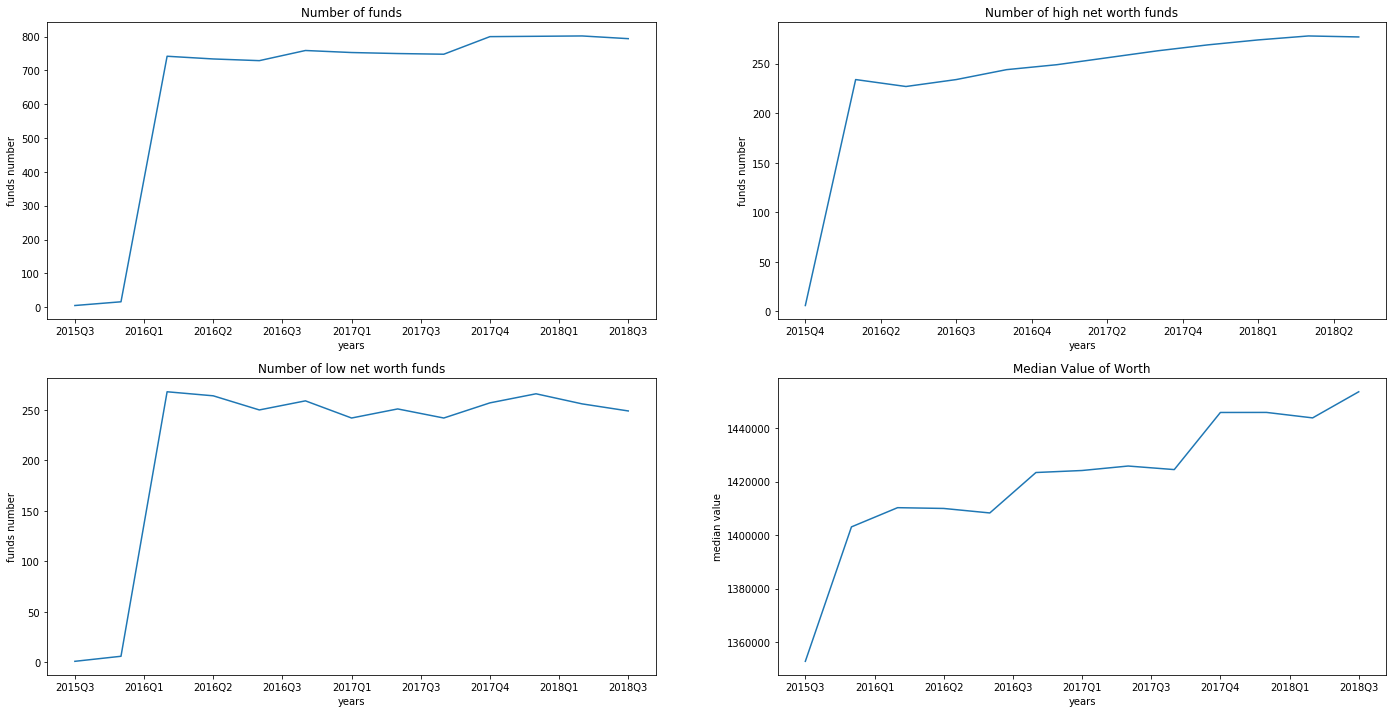

In [20] used 21.9688 MiB RAM in 1.19s, peaked 5.38 MiB above current, total RAM usage 2291.71 MiB


In [20]:
fig, axs = pl.subplots(2, 2, figsize=(24, 12));

plot_data = funds_value.groupby('period')['cik'].nunique()
axs[0, 0].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[0, 0].set_title('Number of funds');
axs[0, 0].set(xlabel='years', ylabel='funds number');
# axs[0, 0].tick_params(axis='x', labelsize=8);
axs[0, 0].xaxis.set_major_locator(pl.MaxNLocator(10));

plot_data = funds_value[funds_value.market_value > high_value].groupby('period')['cik'].nunique()
axs[0, 1].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[0, 1].set_title('Number of high net worth funds');
axs[0, 1].set(xlabel='years', ylabel='funds number');
axs[0, 1].xaxis.set_major_locator(pl.MaxNLocator(10));

plot_data = funds_value[funds_value.market_value < low_value].groupby('period')['cik'].nunique()
axs[1, 0].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[1, 0].set_title('Number of low net worth funds');
axs[1, 0].set(xlabel='years', ylabel='funds number');
axs[1, 0].xaxis.set_major_locator(pl.MaxNLocator(10));

plot_data = funds_value.groupby('period')['cik'].median()
axs[1, 1].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[1, 1].set_title('Median Value of Worth');
axs[1, 1].set(xlabel='years', ylabel='median value');
axs[1, 1].xaxis.set_major_locator(pl.MaxNLocator(10));

Мы видим, что в нашем датасете до 2017 года фондов почти не было (их было меньше 100). Далее произошло резкое увеличение числа инвесторов, причем значительную их долю составили средние фонды, которые продолжают доминировать по количеству. Замеиим, что медианная стоимость упала в первом квартале 2016-го года, когда бурно увеличилось количество фондов в выборке. Это означает, что большинство пришедших фондов, несмотря на мое деление, были ближе к бедным, чем к богатым. Кроме того, в последнее время количество фондов в выборке уменьшилось. 

In [21]:
final_df = final_df[final_df.period >= '2016Q1']

In [21] used -45.8164 MiB RAM in 0.70s, peaked 335.68 MiB above current, total RAM usage 2245.90 MiB


Теперь я посмотрю на распределение ценности фондов.

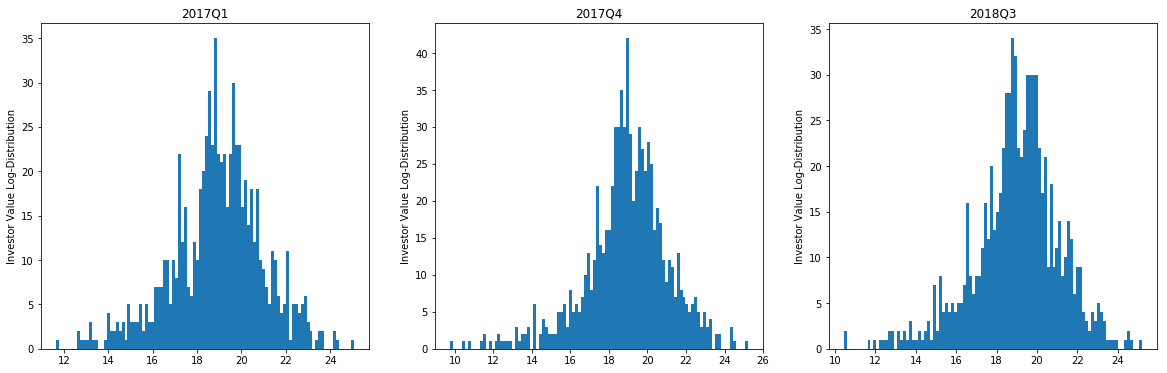

In [22] used 8.2109 MiB RAM in 1.20s, peaked 2.18 MiB above current, total RAM usage 2254.11 MiB


In [22]:
fig, axs = pl.subplots(1, 3, figsize=(20,6));

axs[0].hist(funds_value[funds_value.period == '2017Q1'].market_value.apply(np.log), bins=100);
axs[0].set_title('2017Q1');

axs[1].hist(funds_value[funds_value.period == '2017Q4'].market_value.apply(np.log), bins=100);
axs[1].set_title('2017Q4');

axs[2].hist(funds_value[funds_value.period == '2018Q3'].market_value.apply(np.log), bins=100);
axs[2].set_title('2018Q3');

for ax in axs.flat:
    ax.set(ylabel='Investor Value Log-Distribution')

Из графиков видно, что распределение незначительно изменялось за последние 2 года. Оно похоже на нормальное (то есть, если мы перейдем из логарифма к изначальным значениям, оно будет логнормальным. Только левый хвост у него больше, так как большинство фондов ближе к бедным, как говорилось выше.

Теперь создам дополнительные регрессоры.

In [23]:
final_df = final_df.merge(funds_value, on=['cik', 'period'], how='left', suffixes=('', '_fund'))
# Логарифмирую ценность фонда как всякую денежную величину
final_df['log_value_fund'] = np.log(final_df.market_value_fund)
# Создаю индикаторные переменные, указывающие на принадлежность фонда к весовой категории
final_df['value_cat'] = pd.qcut(final_df.market_value_fund, 10, labels=list(range(10)))

In [23] used 48.9023 MiB RAM in 3.49s, peaked 369.00 MiB above current, total RAM usage 2303.01 MiB


In [24]:
final_df = final_df[~final_df.market_value_fund.isna()]
final_df = final_df.sort_values(by=['ticker_id', 'cik', 'period'])

In [24] used -49.3164 MiB RAM in 2.86s, peaked 442.70 MiB above current, total RAM usage 2253.70 MiB


Создаю лаговые значения, связанные с акциями, для каждого наблюдения. Кроме того, создаю основную переменную, представляющую изменение количества акций тикера. Её я и буду предсказывать. Важно уточнить, что изменение считается от количества акций в предыдущем квартале.

In [25]:
%%time

# Считаю разницу кварталов, чтобы брать только те значения для лагов, которые из предыдущего квартала

# Иначе может выйти так, что я буду создавать лаги на наблюдение, которое было несколько кварталов назад
# Такая ситуация нам не нужна, так как это означает, что фирма тогда закончила инвестирование в эту акцию,
# а потом заново возобновила по другим, возможно, причинам, и начался новый цикл инвестирования в этот тикер
final_df['quarter_sum'] = final_df.period.dt.year * 4 + final_df.period.dt.quarter - 1

# Добавлю индекс комбинации тикера и инвестора для удобства в агрегировании
final_df['object'] = final_df.ticker_id.apply(str) + '_' + final_df.cik.apply(str)

# Создаю лаги для переменных размера фондов
for lag in range(1, num_lags + 1):

    final_df['market_value_fund_lag' + '_' + str(lag)] = final_df.market_value_fund.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_sum.diff(periods=lag) == lag))
    if lag == 1:
        
        final_df['diff_value_fund_lag' + '_' + str(lag)] = \
            (final_df['market_value_fund'] - final_df['market_value_fund_lag' + '_' + str(lag)])
        
        final_df['diff_value_fund_rank_lag' + '_' + str(lag)] = final_df['diff_value_fund_lag' + '_' + str(lag)].rank(pct=True)
    
    else:
        final_df['diff_value_fund_lag' + '_' + str(lag)] = \
            (final_df['market_value_fund_lag' + '_' + str(lag - 1)] - final_df['market_value_fund_lag' + '_' + str(lag)])
        
        final_df['diff_value_fund_rank_lag' + '_' + str(lag)] = final_df['diff_value_fund_lag' + '_' + str(lag)].rank(pct=True)
        
# Создаю переменную, выражающую долю акции в потрфеле

final_df['ticker_share'] = final_df.market_value.div(final_df.market_value_fund, axis=0)

Wall time: 5.88 s
In [25] used 446.9844 MiB RAM in 5.99s, peaked 43.80 MiB above current, total RAM usage 2700.68 MiB


## Создание зависимой переменной

In [26]:
final_df['ym_stamp'] = pd.to_datetime(final_df.stamp).dt.to_period('M')

In [26] used 37.4727 MiB RAM in 0.70s, peaked 0.00 MiB above current, total RAM usage 2738.15 MiB


In [27]:
prices = final_df.groupby(['period', 'ticker_id', 'ym_stamp'])['close'].median().reset_index()
prices.rename(columns={'close': 'mode_close'}, inplace=True)

prices = prices.groupby(['period', 'ticker_id']).first().reset_index().drop('ym_stamp', axis=1)

final_df = final_df.merge(prices, on=['period', 'ticker_id'], suffixes=(False, False), how='left')

final_df['close'] = final_df.close.fillna(final_df.mode_close)

In [27] used 73.3125 MiB RAM in 4.00s, peaked 554.45 MiB above current, total RAM usage 2811.46 MiB


In [28]:
%%time

final_df['close_lag_1'] = final_df.close.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['shares_lag_1'] = final_df.shares.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['net_changes'] = final_df.close_lag_1 * (final_df.shares - final_df.shares_lag_1) \
                                                            / final_df.market_value_fund_lag_1

net_changes = final_df.groupby(by=['period', 'cik']).agg({'net_changes': lambda x: x.abs().sum(min_count=1)}).reset_index()

final_df = final_df.merge(net_changes, on=['period', 'cik'], how='left', suffixes=('', '_abs_sum'))

final_df['pct_in_change'] = final_df.net_changes.div(final_df.net_changes_abs_sum.add(1e-20), axis = 0)

# Создаю предсказываю переменную и её лаги
for lag in range(1, num_lags + 1):

    final_df['pct_in_change' + '_' + str(lag)] = final_df.pct_in_change.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_sum.diff(periods=lag) == lag))
    
    final_df['net_changes' + '_' + str(lag)] = final_df.net_changes.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_sum.diff(periods=lag) == lag))

Wall time: 9.13 s
In [28] used 222.6211 MiB RAM in 9.24s, peaked 500.70 MiB above current, total RAM usage 3034.09 MiB


But at what cost?

In [29]:
final_df[final_df.net_changes < -1].net_changes

574146    -1.0
2030895   -1.0
Name: net_changes, dtype: float64

In [29] used -1226.9727 MiB RAM in 2.46s, peaked 2081.22 MiB above current, total RAM usage 1807.11 MiB


In [30]:
final_df[(final_df.close - final_df.mode_close).abs() >= 7][['cik', 'period', 'ticker_id', 'shares', 'market_value',
                                                                  'close', 'mode_close']].head(20)

,cik,period,ticker_id,shares,market_value,close,mode_close
817,1423442,2016Q4,784,115212.0,3411000.0,29.606291,21.069145
1360,1588539,2018Q2,829,72.0,1000.0,13.888889,22.607722
1361,1588539,2018Q3,829,72.0,1000.0,13.888889,21.471297
1632,1134008,2017Q2,835,47.0,1000.0,21.276596,11.657993
1670,1209324,2018Q3,835,47.0,1000.0,21.276596,11.299665
2090,1592180,2017Q4,838,49.0,1000.0,20.408163,29.527810
2681,1521001,2018Q3,902,40.0,1000.0,25.000000,32.248703
3435,14661,2016Q3,978,7.0,1000.0,142.857143,71.870002
3437,14661,2017Q1,978,7.0,1000.0,142.857143,72.421990
3439,14661,2017Q3,978,7.0,1000.0,142.857143,81.390054


In [30] used 1.4336 MiB RAM in 0.26s, peaked 20.74 MiB above current, total RAM usage 1808.55 MiB


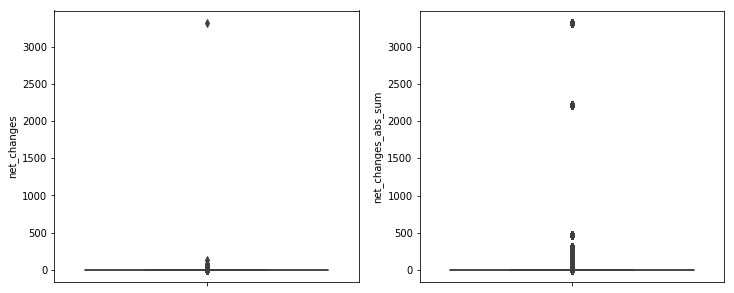

In [31] used 52.7031 MiB RAM in 4.97s, peaked 41.32 MiB above current, total RAM usage 1861.25 MiB


In [31]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y=final_df["net_changes"], ax=ax[0]);
sns.boxplot(y=(final_df["net_changes_abs_sum"]), ax=ax[1]);
fig.show();

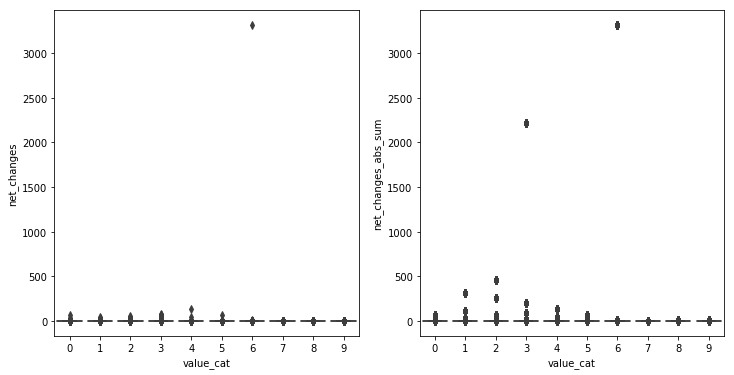

In [32] used 70.3047 MiB RAM in 4.56s, peaked 22.14 MiB above current, total RAM usage 1931.55 MiB


In [32]:
fig, ax = pl.subplots(1,2, figsize=(12,6));
sns.boxplot(x="value_cat", y="net_changes", data=final_df, ax=ax[0]);
sns.boxplot(x="value_cat", y="net_changes_abs_sum", data=final_df, ax=ax[1]);

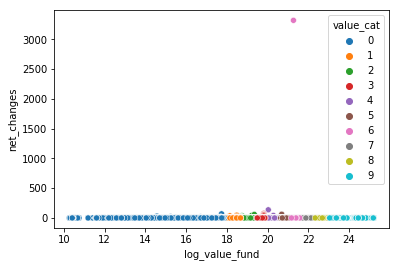

In [33] used 146.0430 MiB RAM in 118.56s, peaked 350.47 MiB above current, total RAM usage 2077.60 MiB


In [33]:
sns.scatterplot(x='log_value_fund', y='net_changes', hue='value_cat', data=final_df);

Проблема просто net_changes в том, что в нем могут быть аутлаеры и изменения сравниваются не с собой, а с имеющимися и накопленными активами.

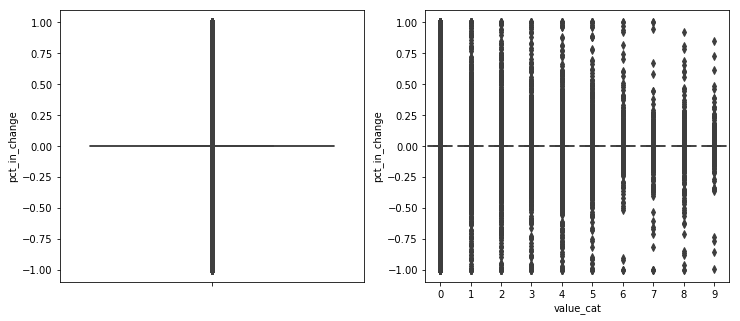

In [34] used 125.3672 MiB RAM in 6.99s, peaked 15.80 MiB above current, total RAM usage 2202.96 MiB


In [34]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y="pct_in_change", data=final_df, ax=ax[0]);
sns.boxplot(x="value_cat", y="pct_in_change", data=final_df, ax=ax[1]);

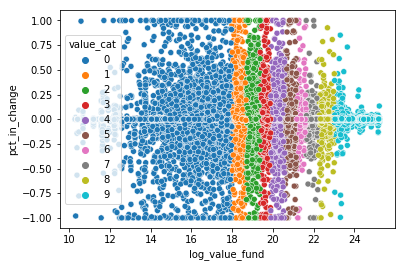

In [35] used -755.9297 MiB RAM in 188.91s, peaked 1244.82 MiB above current, total RAM usage 1447.04 MiB


In [35]:
sns.scatterplot(x='log_value_fund', y='pct_in_change', hue='value_cat', data=final_df);

## Метрики стиля инвестирования

Сейчас я посмотрю на то, как фонды торгуют через призму стандартных метрик. С помощью этого я постараюсь добавить переменные, которые бы контролировали стиль фонда, ибо в зависимости от стиля инвестирования может меняться отношение к активам.

### Turnover и HHI

Считаю такие классные и потрясающие (реально же) метрики как turnover и индекс Херфиндаля-Хиршмана (HHI) для того, чтобы разграничить фонды по типам инвестирования и проводить контроль по ним. 

Сначала вычислю turnover.

In [36]:
final_df['ticker_share_lag_1'] = final_df.ticker_share.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['ticker_share_lag_2'] = final_df.ticker_share.shift(periods=2). \
                                          where((final_df.object == final_df.object.shift(periods=4)) &
                                                (final_df.quarter_sum.diff(periods=2) == 2))

final_df['ticker_share_lag_4'] = final_df.ticker_share.shift(periods=4). \
                                          where((final_df.object == final_df.object.shift(periods=4)) &
                                                (final_df.quarter_sum.diff(periods=4) == 4))

In [36] used 170.6406 MiB RAM in 1.08s, peaked 20.64 MiB above current, total RAM usage 1617.68 MiB


In [37]:
turnover = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_1']).sum(min_count=1)).reset_index()
turnover.rename(columns={0: 'turnover'}, inplace=True)
turnover.sample(5)

,period,cik,turnover
5602,2017Q4,1427514,0.160351
4298,2017Q2,1591744,0.916345
6547,2018Q1,1568190,1.087679
2385,2016Q4,1106129,0.298007
6358,2018Q1,1390205,0.281430


In [37] used -215.2500 MiB RAM in 17.09s, peaked 2022.34 MiB above current, total RAM usage 1402.43 MiB


In [38]:
turnover_halfyear = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_2']).sum(min_count=1)).reset_index()
turnover_halfyear.rename(columns={0: 'turnover_halfyear'}, inplace=True)
turnover_halfyear.sample(5)

,period,cik,turnover_halfyear
626,2016Q1,1599425,NaN
6673,2018Q1,1641891,0.894754
5976,2017Q4,1712901,NaN
6150,2018Q1,1055951,0.780322
756,2016Q2,98758,NaN


In [38] used 8.2422 MiB RAM in 15.80s, peaked 1820.12 MiB above current, total RAM usage 1410.67 MiB


In [39]:
turnover_year = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_4']).sum(min_count=1)).reset_index()
turnover_year.rename(columns={0: 'turnover_year'}, inplace=True)
turnover_year.sample(5)

,period,cik,turnover_year
2658,2016Q4,1508822,NaN
476,2016Q1,1512145,NaN
1625,2016Q3,1063571,NaN
7596,2018Q2,1730466,NaN
6779,2018Q1,1721242,NaN


In [39] used 0.7148 MiB RAM in 11.81s, peaked 1820.14 MiB above current, total RAM usage 1411.38 MiB


Теперь HHI.

In [40]:
hhi = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.square(x['ticker_share']).sum(min_count=1)).reset_index()
hhi.rename(columns={0: 'hhi'}, inplace=True)
hhi.head()

,period,cik,hhi
0,2016Q1,3520,0.017218
1,2016Q1,8565,0.648686
2,2016Q1,9015,0.004477
3,2016Q1,9634,0.053793
4,2016Q1,14661,0.048942


In [40] used 0.6250 MiB RAM in 9.61s, peaked 1820.14 MiB above current, total RAM usage 1412.01 MiB


Теперь посмотрю на их распределение.

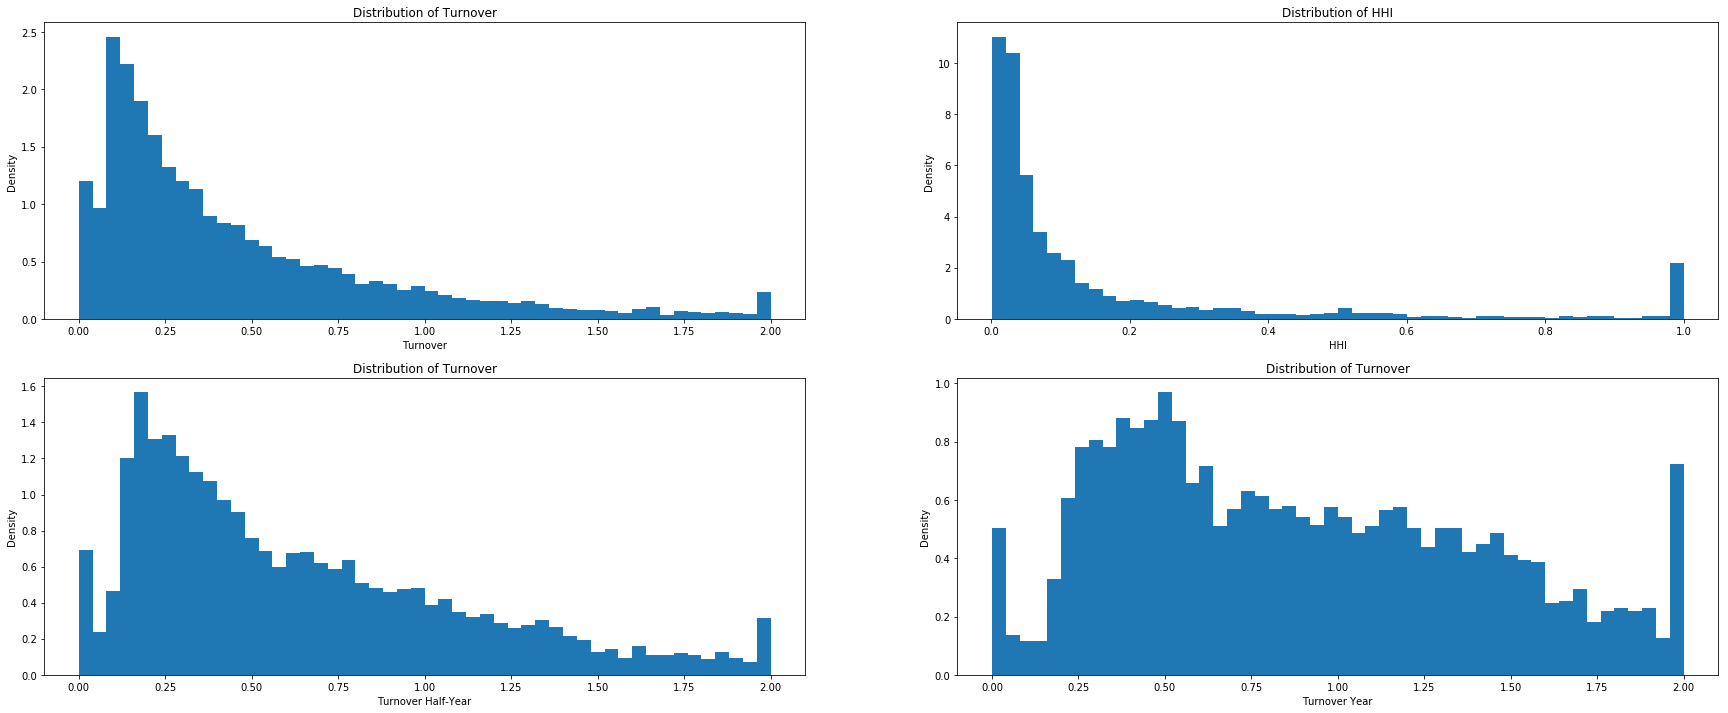

In [41] used 16.8789 MiB RAM in 1.16s, peaked 6.86 MiB above current, total RAM usage 1428.89 MiB


In [41]:
fig, axs = pl.subplots(2, 2, figsize=(30,12));

axs[0, 0].hist(turnover.turnover, density=True, bins=50);
axs[0, 0].set_title('Distribution of Turnover');
axs[0, 0].set(xlabel='Turnover', ylabel='Density');

axs[0, 1].hist(hhi.hhi, density=True, bins=50);
axs[0, 1].set_title('Distribution of HHI');
axs[0, 1].set(xlabel='HHI', ylabel='Density');

axs[1, 0].hist(turnover_halfyear.turnover_halfyear, density=True, bins=50);
axs[1, 0].set_title('Distribution of Turnover');
axs[1, 0].set(xlabel='Turnover Half-Year', ylabel='Density');

axs[1, 1].hist(turnover_year.turnover_year, density=True, bins=50);
axs[1, 1].set_title('Distribution of Turnover');
axs[1, 1].set(xlabel='Turnover Year', ylabel='Density');

Можно заметить, что их распределения похожи на геометрическое/Пуассона. Можно разграничить фонды по этим категориям, установив границы для каждого из критерия. Например, 0.5 для Turnover и 0.2 для HHI. Также отметим условно экстремальные ситуации, когда и Turnover, и HHI равны единице.

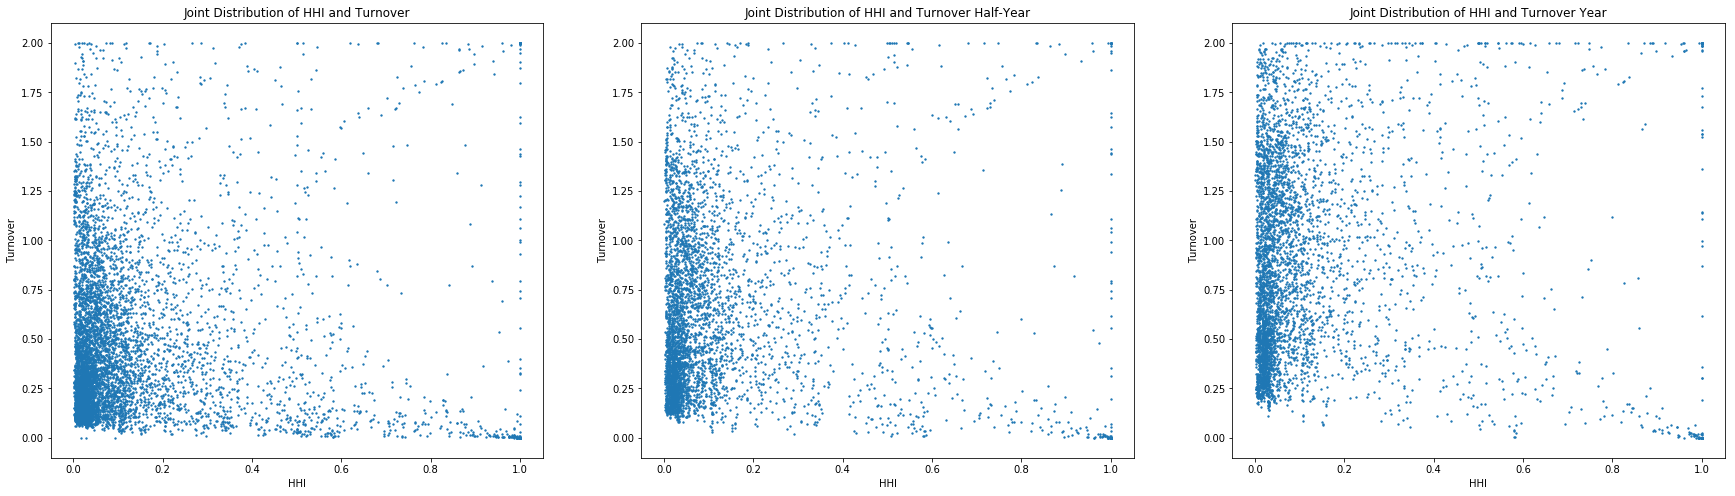

In [42] used 7.2305 MiB RAM in 0.80s, peaked 0.76 MiB above current, total RAM usage 1436.12 MiB


In [42]:
fig, axs = pl.subplots(1, 3, figsize=(30,8));

axs[0].scatter(hhi.hhi, turnover.turnover, s=1.8);
axs[0].set_xlabel('HHI');
axs[0].set_ylabel('Turnover');
axs[0].set_title('Joint Distribution of HHI and Turnover');

axs[1].scatter(hhi.hhi, turnover_halfyear.turnover_halfyear, s=1.8);
axs[1].set_xlabel('HHI');
axs[1].set_ylabel('Turnover');
axs[1].set_title('Joint Distribution of HHI and Turnover Half-Year');

axs[2].scatter(hhi.hhi, turnover_year.turnover_year, s=1.8);
axs[2].set_xlabel('HHI');
axs[2].set_ylabel('Turnover');
axs[2].set_title('Joint Distribution of HHI and Turnover Year');

Если мы посмотрим на совместное их распределение, то не увидим каких-то кластеров. Но подозрительно выделяются наблюдения с HHI=1 (фонды с одной акцией). Вопрос - как такие фонды существуют/как они попали к нам в выборку? Установим контроль и на них.

Ещё в правых частях графиков можно наблюдать некую параболу. Она словно принимает минимальное значение при $Turnover=1$, равное $HHI=0.5$. Кроме того, при $Turnover \in \{0, 2\}$ она принимает значение $HHI=1$. Такой параболе соответствует уравнение:

$$HHI = \frac{{Turnover}^2}{2} - {Turnover} + 1$$ 

Я утверждаю, что такая парабола соответствует тем фондам, у которых в предыдущем периоде были активы только одного тикера, а в текущем добавился ещё один. Этот "один тикер" можно с погрешностью воспринимать как несколько тикеров, среди которых купленные активы одного из них значительно превышают остальные.

Итак, введем обозначения.

Пусть $x_{1,t_{0}} \gt 0$ - доля единственного тикера тикера в предыдущем периоде, $x_{1,t_{1}}=1$ - его же доля в текущем периоде, а $x_{2,t_{1}} \gt 0$ - доля купленного в текущем периоде нового тикера.
Тогда:
$$HHI = x_{1,t_{1}}^2 + x_{2,t_{1}}^2,$$
$$Turnover = |x_{1,t_{1}} - x_{1,t_{0}}| + |x_{2,t_{1}}| = 1 - x_{1,t_{1}} + x_{2,t_{1}}.$$
Кроме того, заметим, что
$$x_{1,t_{1}} + x_{2,t_{1}} = 1.$$

Теперь рассмотрим правую часть равенства (уравнение параболы). Раскроем его, подставив формулу Turnover.

$$ \frac{{(1 - x_{1,t_{1}} + x_{2,t_{1}})}^2}{2} - (1 - x_{1,t_{1}} + x_{2,t_{1}}) + 1 =
\frac{{(1  +  2 \cdot (x_{2,t_{1}} - x_{1,t_{1}}) + (x_{2,t_{1}} - x_{1,t_{1}})^2)}}{2} - 1 + x_{1,t_{1}} - x_{2,t_{1}} + 1 =
\frac{{(1 + (x_{2,t_{1}} - x_{1,t_{1}})^2)}}{2} + (x_{2,t_{1}} - x_{1,t_{1}}) - (x_{2,t_{1}} - x_{1,t_{1}}) = 
\frac{{(1 + (x_{2,t_{1}} - x_{1,t_{1}})^2)}}{2} = \frac{1}{2} + \frac{{(x_{2,t_{1}} - x_{1,t_{1}})^2}}{2} 
= \frac{1}{2} + \frac{{x_{2,t_{1}}^2 + x_{1,t_{1}}^2 - 2 \cdot (x_{2,t_{1}} \cdot x_{1,t_{1}})}}{2}
= \frac{1}{2} + \frac{{x_{2,t_{1}}^2 + x_{1,t_{1}}^2}}{2} - \frac{{2 \cdot (x_{2,t_{1}} \cdot x_{1,t_{1}})}}{2} $$

Теперь подставим преобразованную часть в исходное равенство, подставив формулу HHI.

$$ x_{1,t_{1}}^2 + x_{2,t_{1}}^2 = \frac{1}{2} + \frac{{x_{2,t_{1}}^2 + x_{1,t_{1}}^2}}{2} - \frac{{2 \cdot (x_{2,t_{1}} \cdot x_{1,t_{1}})}}{2}$$

Теперь домножим обе части равенства на два, приведем подобные слагаемые и перенесем все переменные в одну часть. Тогда получится следующее.

$$ x_{1,t_{1}}^2 + x_{2,t_{1}}^2 + 2 \cdot x_{2,t_{1}} \cdot x_{1,t_{1}} = 1 $$

Заметим, что слева у нас полный квадрат, поэтому

$$ (x_{2,t_{1}} + x_{1,t_{1}})^2 = 1. $$

Но мы тогда возвращаемся к начальному условию, которое говорит, что $x_{1,t_{1}} + x_{2,t_{1}} = 1$. Это значит, что данная зависимость верна для любого фонда, которые перешел от инвестирования в один тикер к инвестированию в два тикера. $\blacksquare$

Из этого следует, что эта парабола совершенно естественная, в отличие от фондов, которые торгуют двумя тикерами, и никакого контроля осуществлять не следует.

Добавляю переменные на основе наблюдений.

In [43]:
# Добавляю сами индексы
final_df = final_df.merge(turnover, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(turnover_halfyear, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(turnover_year, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(hhi, on=['cik', 'period'], how='left', suffixes=(False, False))

# Устанавливаю контроль на фонды с одной акцией
final_df['hhi_eq_1'] = final_df.hhi.eq(1)

In [43] used 85.0352 MiB RAM in 10.54s, peaked 1460.35 MiB above current, total RAM usage 1521.15 MiB


In [44]:
# Разграничиваю фонды по метрикам через индикаторы
final_df['hhi_cat'] = pd.cut(final_df.hhi, np.insert((1 / np.arange(10, 0, -1)) ** 1.5, 0, -1), labels=np.arange(10))
final_df['tvr_cat'] = pd.cut(final_df.turnover, np.insert((2 / np.arange(10, 0, -1)) ** 1.7, 0, -1), labels=np.arange(10))
final_df['tvr_half_cat'] = pd.cut(final_df.turnover_halfyear, np.insert((2 / np.arange(10, 0, -1)) ** 1.7, 0, -1),
                                                                                                labels=np.arange(10))
final_df['tvr_year_cat'] = pd.cut(final_df.turnover_year, np.insert((2 / np.arange(10, 0, -1)) ** 1.7, 0, -1),
                                                                                                labels=np.arange(10))

In [44] used 9.4453 MiB RAM in 0.52s, peaked 36.87 MiB above current, total RAM usage 1530.60 MiB


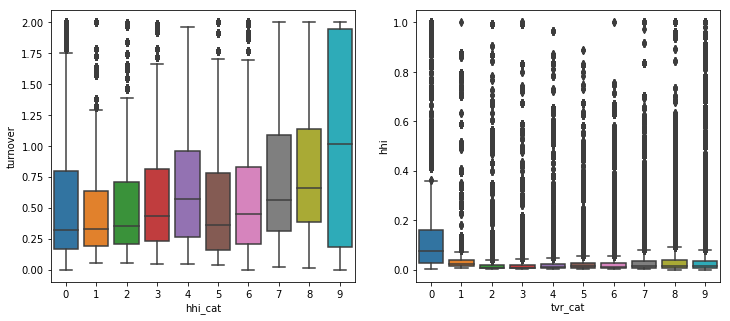

In [45] used 43.7773 MiB RAM in 2.25s, peaked 31.13 MiB above current, total RAM usage 1574.38 MiB


In [45]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover', data=final_df, ax=ax[0]);
sns.boxplot(x='tvr_cat', y='hhi', data=final_df, ax=ax[1]);

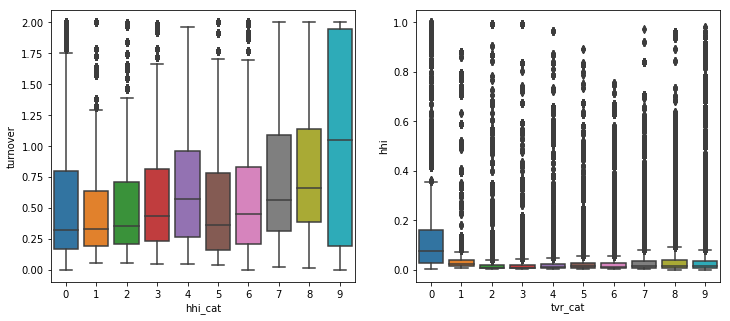

In [46] used 966.2305 MiB RAM in 5.16s, peaked 351.12 MiB above current, total RAM usage 2540.61 MiB


In [46]:
final_df_slice = final_df[final_df.hhi.ne(1)]

fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover', data=final_df_slice, ax=ax[0]);
sns.boxplot(x='tvr_cat', y='hhi', data=final_df_slice, ax=ax[1]);

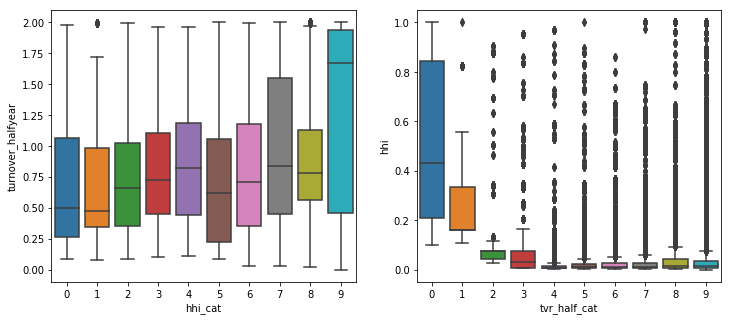

In [47] used 21.9961 MiB RAM in 1.51s, peaked 38.34 MiB above current, total RAM usage 2562.60 MiB


In [47]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover_halfyear', data=final_df, ax=ax[0]);
sns.boxplot(x='tvr_half_cat', y='hhi', data=final_df, ax=ax[1]);

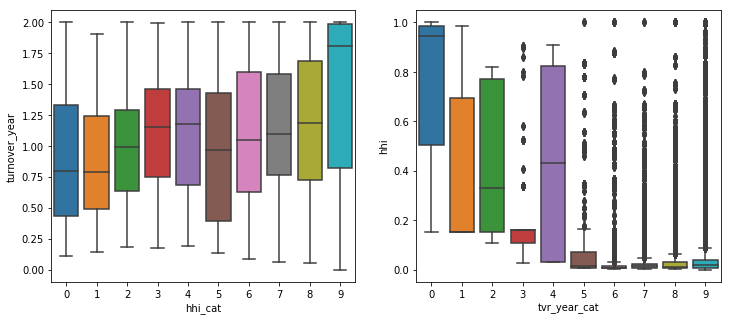

In [48] used 10.9219 MiB RAM in 2.48s, peaked 40.23 MiB above current, total RAM usage 2573.52 MiB


In [48]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover_year', data=final_df, ax=ax[0]);
sns.boxplot(x='tvr_year_cat', y='hhi', data=final_df, ax=ax[1]);

Если мы посмотрим на совместное распределение Размера фонда и наших метрик, то опять не увидим каких-либо кластеров, по которым можно было бы провести классификацию. Печаль.

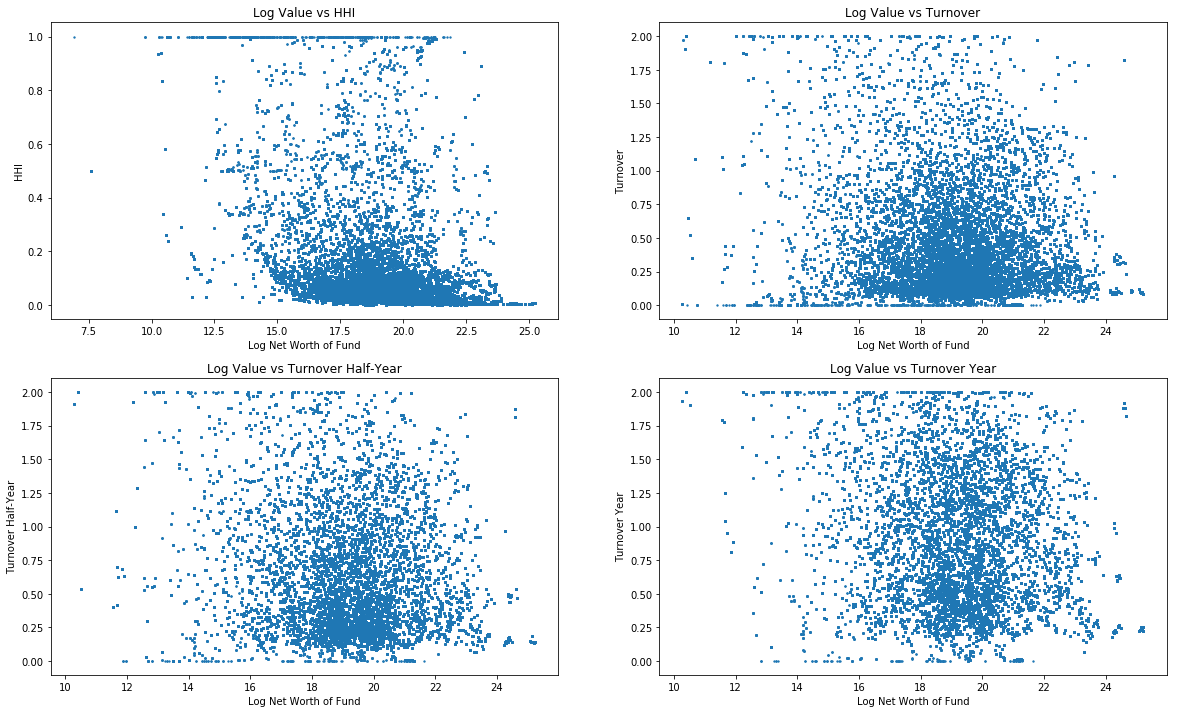

In [49] used 116.3203 MiB RAM in 70.75s, peaked 16.99 MiB above current, total RAM usage 2689.84 MiB


In [49]:
fig, axs = pl.subplots(2, 2, figsize=(20,12));

axs[0, 0].scatter(final_df.log_value_fund,
           final_df.hhi, s=1.8);
axs[0, 0].set_title('Log Value vs HHI');
axs[0, 0].set(xlabel='Log Net Worth of Fund', ylabel='HHI');

axs[0, 1].scatter(final_df.log_value_fund,
           final_df.turnover, s=1.8);
axs[0, 1].set_title('Log Value vs Turnover');
axs[0, 1].set(xlabel='Log Net Worth of Fund', ylabel='Turnover');

axs[1, 0].scatter(final_df.log_value_fund,
           final_df.turnover_halfyear, s=1.8);
axs[1, 0].set_title('Log Value vs Turnover Half-Year');
axs[1, 0].set(xlabel='Log Net Worth of Fund', ylabel='Turnover Half-Year');

axs[1, 1].scatter(final_df.log_value_fund,
           final_df.turnover_year, s=1.8);
axs[1, 1].set_title('Log Value vs Turnover Year');
axs[1, 1].set(xlabel='Log Net Worth of Fund', ylabel='Turnover Year');

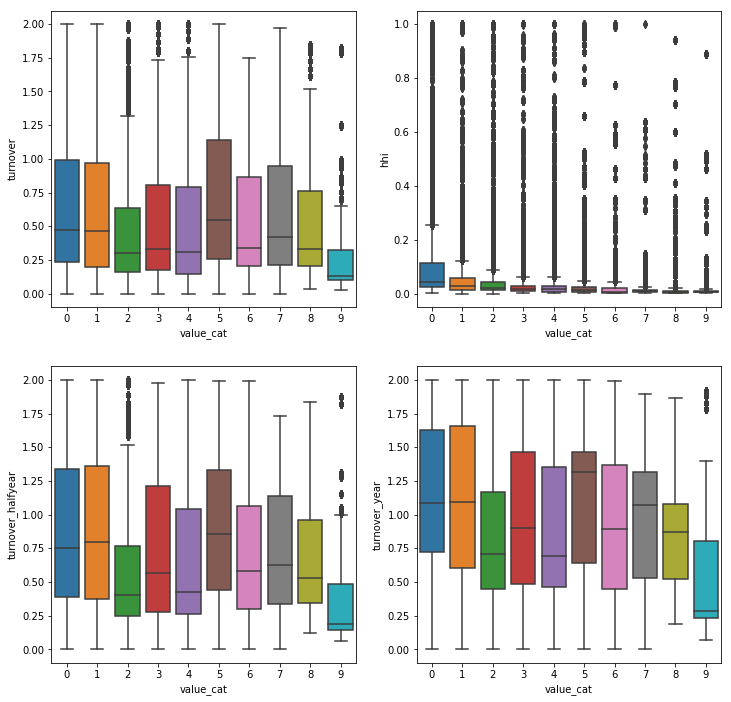

In [50] used 32.8398 MiB RAM in 3.47s, peaked 31.36 MiB above current, total RAM usage 2722.68 MiB


In [50]:
fig, ax = pl.subplots(2,2, figsize=(12,12));
sns.boxplot(x='value_cat', y='turnover', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='value_cat', y='hhi', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='value_cat', y='turnover_halfyear', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='value_cat', y='turnover_year', data=final_df, ax=ax[1, 1]);

Теперь я посмотрю на совместное распределение с зависимой переменной изменения количества акций, чтобы лучше понять зависимость от класса фонда.

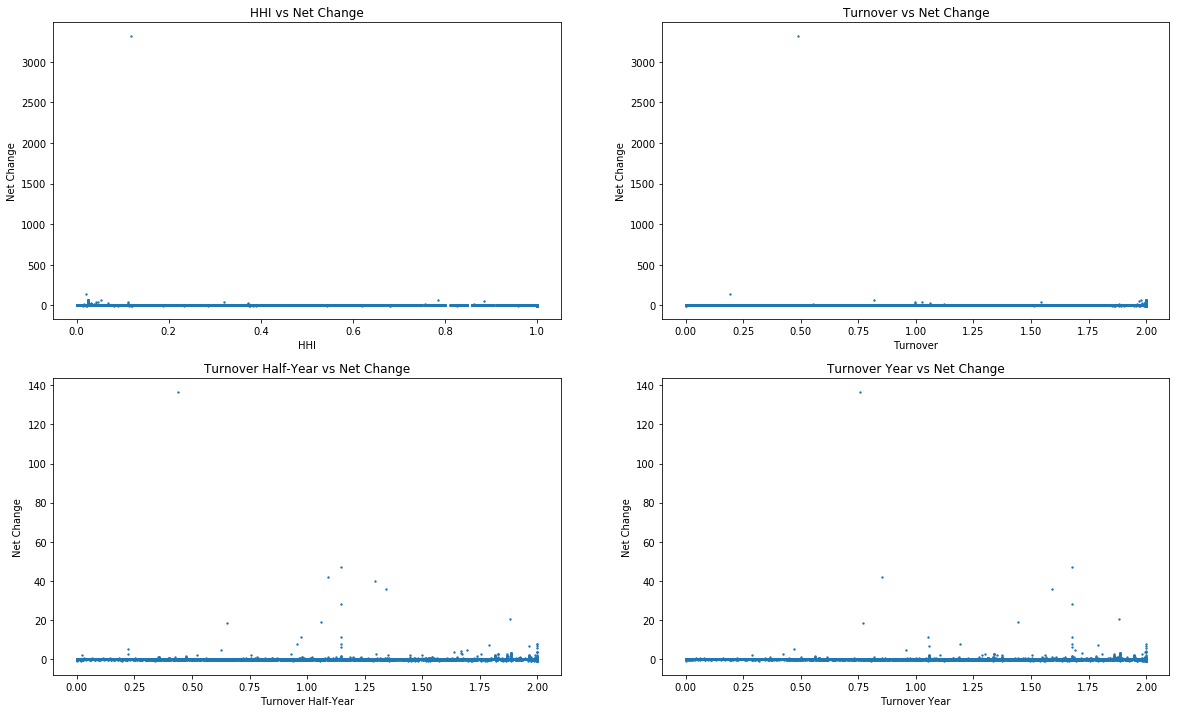

In [51] used 106.5508 MiB RAM in 63.38s, peaked 16.71 MiB above current, total RAM usage 2829.23 MiB


In [51]:
fig, axs = pl.subplots(2, 2, figsize=(20,12));

axs[0, 0].scatter(final_df.hhi,
           final_df.net_changes, s=1.8);
axs[0, 0].set_title('HHI vs Net Change');
axs[0, 0].set(xlabel='HHI', ylabel='Net Change');

axs[0, 1].scatter(final_df.turnover,
           final_df.net_changes, s=1.8);
axs[0, 1].set_title('Turnover vs Net Change');
axs[0, 1].set(xlabel='Turnover', ylabel='Net Change');

axs[1, 0].scatter(final_df.turnover_halfyear,
           final_df.net_changes, s=1.8);
axs[1, 0].set_title('Turnover Half-Year vs Net Change');
axs[1, 0].set(xlabel='Turnover Half-Year', ylabel='Net Change');

axs[1, 1].scatter(final_df.turnover_year,
           final_df.net_changes, s=1.8);
axs[1, 1].set_title('Turnover Year vs Net Change');

axs[1, 1].set(xlabel='Turnover Year', ylabel='Net Change');

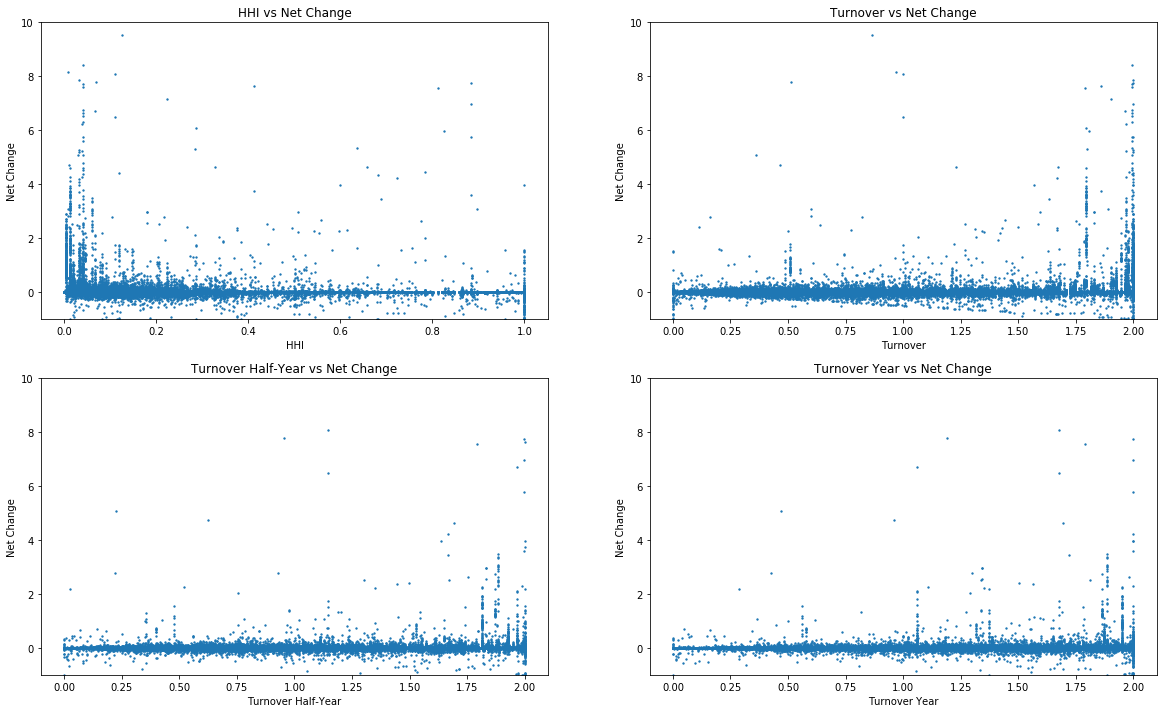

In [52] used -7.7891 MiB RAM in 74.00s, peaked 129.45 MiB above current, total RAM usage 2821.45 MiB


In [52]:
fig, axs = pl.subplots(2, 2, figsize=(20,12));

axs[0, 0].scatter(final_df.hhi,
           final_df.net_changes, s=1.8);
axs[0, 0].set_title('HHI vs Net Change');
axs[0, 0].set(xlabel='HHI', ylabel='Net Change');
axs[0, 0].set_ylim(-1, 10);

axs[0, 1].scatter(final_df.turnover,
           final_df.net_changes, s=1.8);
axs[0, 1].set_title('Turnover vs Net Change');
axs[0, 1].set(xlabel='Turnover', ylabel='Net Change');
axs[0, 1].set_ylim(-1, 10);

axs[1, 0].scatter(final_df.turnover_halfyear,
           final_df.net_changes, s=1.8);
axs[1, 0].set_title('Turnover Half-Year vs Net Change');
axs[1, 0].set(xlabel='Turnover Half-Year', ylabel='Net Change');
axs[1, 0].set_ylim(-1, 10);

axs[1, 1].scatter(final_df.turnover_year,
           final_df.net_changes, s=1.8);
axs[1, 1].set_title('Turnover Year vs Net Change');
axs[1, 1].set(xlabel='Turnover Year', ylabel='Net Change');
axs[1, 1].set_ylim(-1, 10);

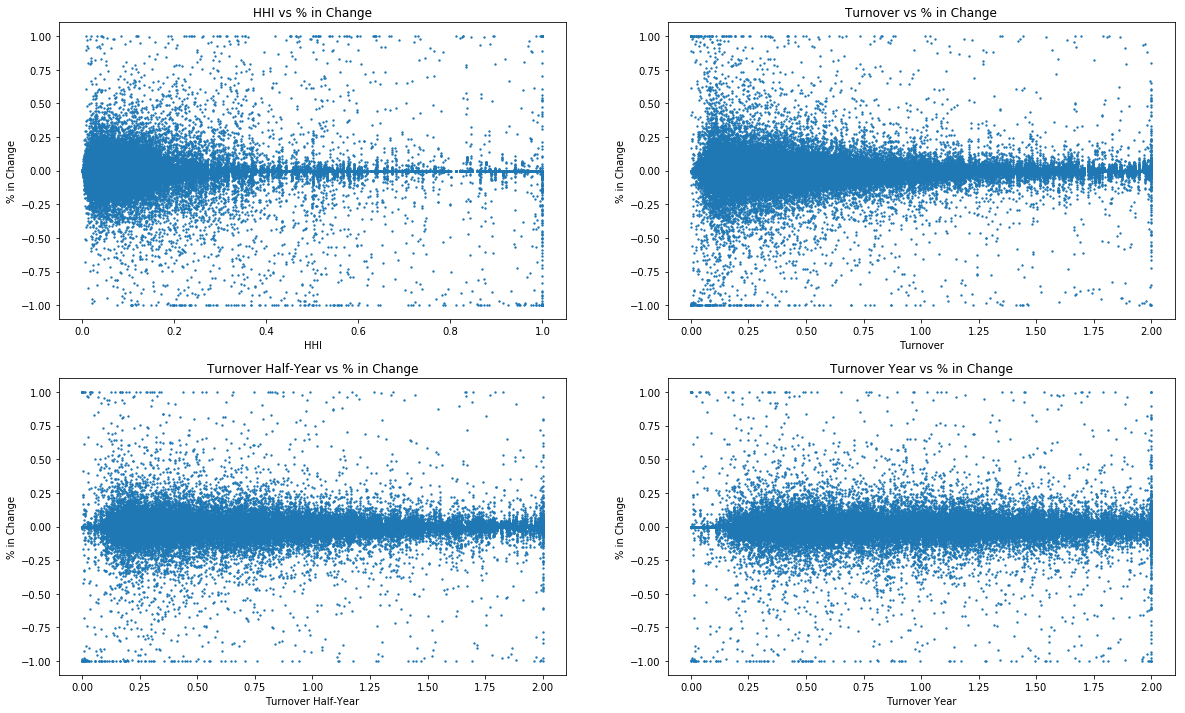

In [53] used -952.4844 MiB RAM in 80.34s, peaked 1014.36 MiB above current, total RAM usage 1868.96 MiB


In [53]:
fig, axs = pl.subplots(2, 2, figsize=(20,12));

axs[0, 0].scatter(final_df.hhi,
           final_df.pct_in_change, s=1.8);
axs[0, 0].set_title('HHI vs % in Change');
axs[0, 0].set(xlabel='HHI', ylabel='% in Change');

axs[0, 1].scatter(final_df.turnover,
           final_df.pct_in_change, s=1.8);
axs[0, 1].set_title('Turnover vs % in Change');
axs[0, 1].set(xlabel='Turnover', ylabel='% in Change');

axs[1, 0].scatter(final_df.turnover_halfyear,
           final_df.pct_in_change, s=1.8);
axs[1, 0].set_title('Turnover Half-Year vs % in Change');
axs[1, 0].set(xlabel='Turnover Half-Year', ylabel='% in Change');

axs[1, 1].scatter(final_df.turnover_year,
           final_df.pct_in_change, s=1.8);
axs[1, 1].set_title('Turnover Year vs % in Change');
axs[1, 1].set(xlabel='Turnover Year', ylabel='% in Change');

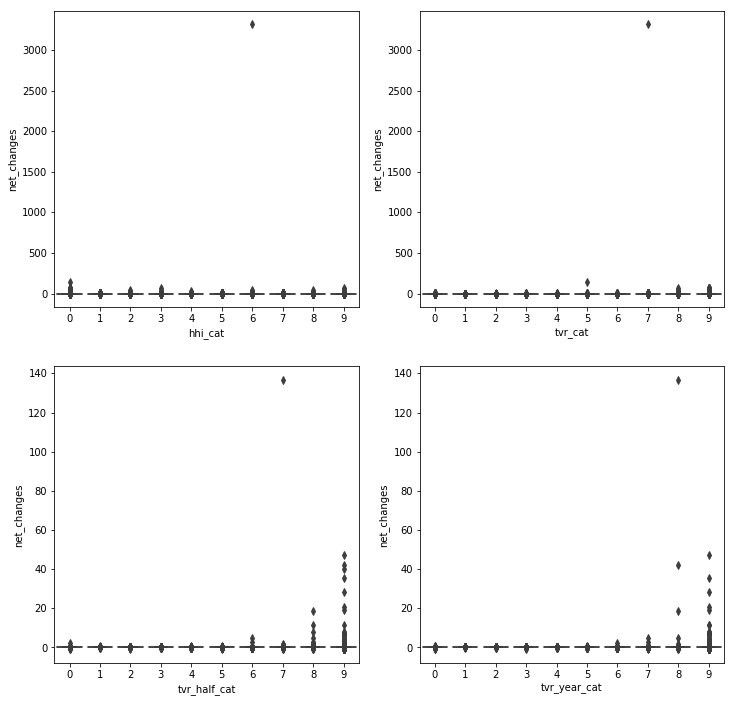

In [54] used -839.6680 MiB RAM in 16.62s, peaked 842.05 MiB above current, total RAM usage 1029.29 MiB


In [54]:
fig, ax = pl.subplots(2,2, figsize=(12,12));
sns.boxplot(x='hhi_cat', y='net_changes', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='tvr_cat', y='net_changes', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='tvr_half_cat', y='net_changes', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='tvr_year_cat', y='net_changes', data=final_df, ax=ax[1, 1]);

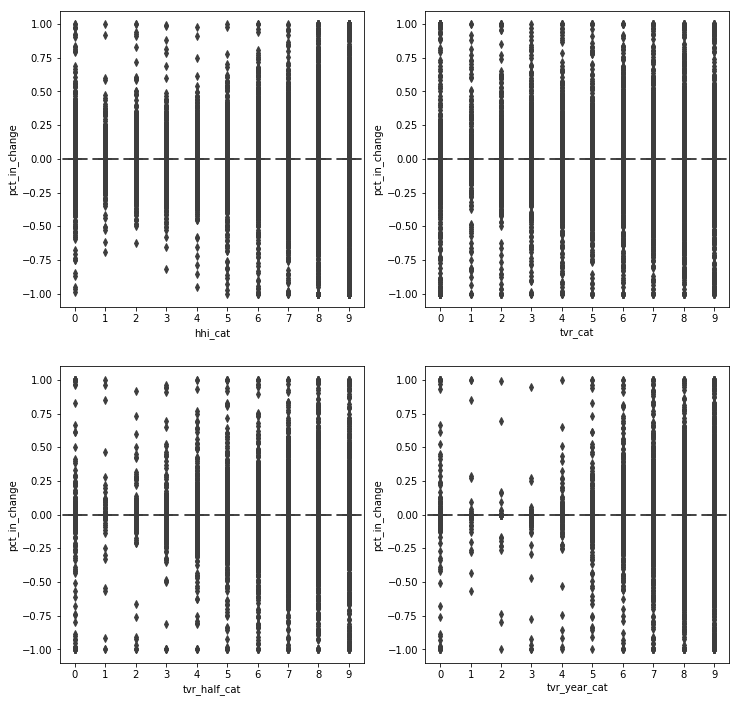

In [55] used -220.1406 MiB RAM in 16.43s, peaked 375.74 MiB above current, total RAM usage 809.15 MiB


In [55]:
fig, ax = pl.subplots(2,2, figsize=(12,12));
sns.boxplot(x='hhi_cat', y='pct_in_change', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='tvr_cat', y='pct_in_change', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='tvr_half_cat', y='pct_in_change', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='tvr_year_cat', y='pct_in_change', data=final_df, ax=ax[1, 1]);

### Количество акций в портфеле

Сейчас я посмотрю на то, как соотносится количество акций в портфеле с его размером и метриками, расмотренными выше.

Сначала я создам таблицу с данными о количестве позиций у фондов.

In [56]:
# Создаю таблицу количества позиций из агрегированных данных
pos_count = final_df.groupby(['period', 'cik']).count().reset_index()[['period', 'cik', 'shares']]
pos_count.rename(columns={'shares': 'pos_count'}, inplace=True)

pos_count.head()

,period,cik,pos_count
0,2016Q1,3520,890
1,2016Q1,8565,2
2,2016Q1,9015,1271
3,2016Q1,9634,232
4,2016Q1,14661,1695


In [56] used -144.8555 MiB RAM in 21.64s, peaked 1030.35 MiB above current, total RAM usage 664.30 MiB


Теперь добавляю эти данные в датасет и пролаггирую их, так как, опять же, нам не доступны данные из периода предсказания.

In [57]:
# Присоединяю новые данные
final_df = final_df.merge(pos_count, on=['period', 'cik'], how='left', suffixes=(False, False))

In [57] used 154.7188 MiB RAM in 18.24s, peaked 1507.30 MiB above current, total RAM usage 819.02 MiB


Теперь посмотрим на распределение количества позиций в фонде.

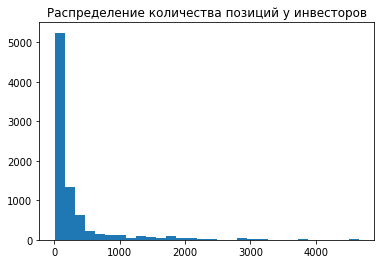

In [58] used 29.2188 MiB RAM in 0.61s, peaked 0.00 MiB above current, total RAM usage 848.23 MiB


In [58]:
pl.hist(pos_count.pos_count, bins=30);
pl.title('Распределение количества позиций у инвесторов');

Мы видим, что распределение фондов похоже на геометрическое. Тогда разобьем его на классы последовательным извлечением половины. В первом классе будут фонды с количеством позиций, большим 2000. Во втором классе - большим 1000. И в третьем - большим 200. Это не деление по половине, но по гистограмме видно, что количество фондов с количеством позиций, меньшим 200, выбивает из сглаженности распределения, что я воспринимаю как сигнал, чтобы сместить границу разделения. Также я отмечу фонды с количеством позиций, большим 3000 и собирают почти все акции на рынке. Они стоят особняком от основного распределения. Вполне возможно, что те самые индексные и квантовые фонды, которые работают по всей вселенной акций.

In [59]:
final_df['pos_count_cat'] = pd.cut(final_df.pos_count, [-1, 30, 200, 500, 1000, 2000, 3000, 1e32],
                                  labels=['<=30', '30-200', '200-500', '500-1000', '1000-2000', '2000-3000', '>3000'])

In [59] used 4.0234 MiB RAM in 0.26s, peaked 24.16 MiB above current, total RAM usage 852.26 MiB


Теперь я посмотрю на совместное распределение корня числа позиций и логарифма ценности фонда.

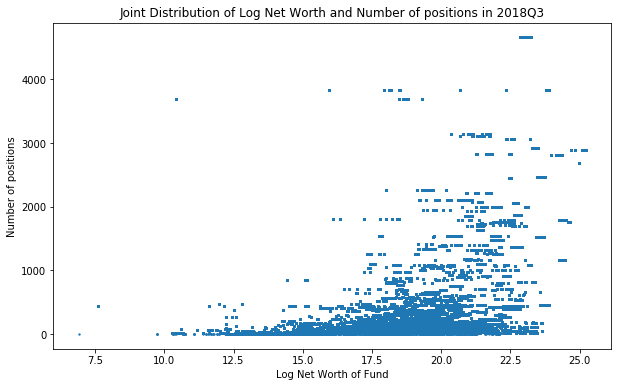

In [60] used 78.4375 MiB RAM in 24.53s, peaked 0.94 MiB above current, total RAM usage 930.70 MiB


In [60]:
fig, axs = pl.subplots(1, 1, figsize=(10,6));

axs.scatter(final_df.log_value_fund,
            final_df.pos_count, s=1.8);
axs.set_title('Joint Distribution of Log Net Worth and Number of positions in ' + str(final_df.period.max()));
axs.set(xlabel='Log Net Worth of Fund', ylabel='Number of positions');

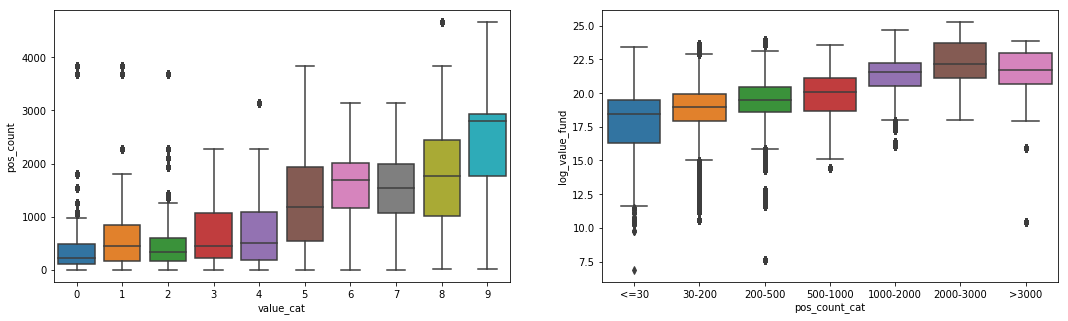

In [61] used 44.5703 MiB RAM in 2.82s, peaked 34.82 MiB above current, total RAM usage 975.27 MiB


In [61]:
fig, ax = pl.subplots(1,2, figsize=(18,5));
sns.boxplot(x='value_cat', y='pos_count', data=final_df, ax=ax[0]);
sns.boxplot(x='pos_count_cat', y='log_value_fund', data=final_df, ax=ax[1]);

Теперь я посмотрю на распределения корня числа позиций относительно HHI и Turnover.

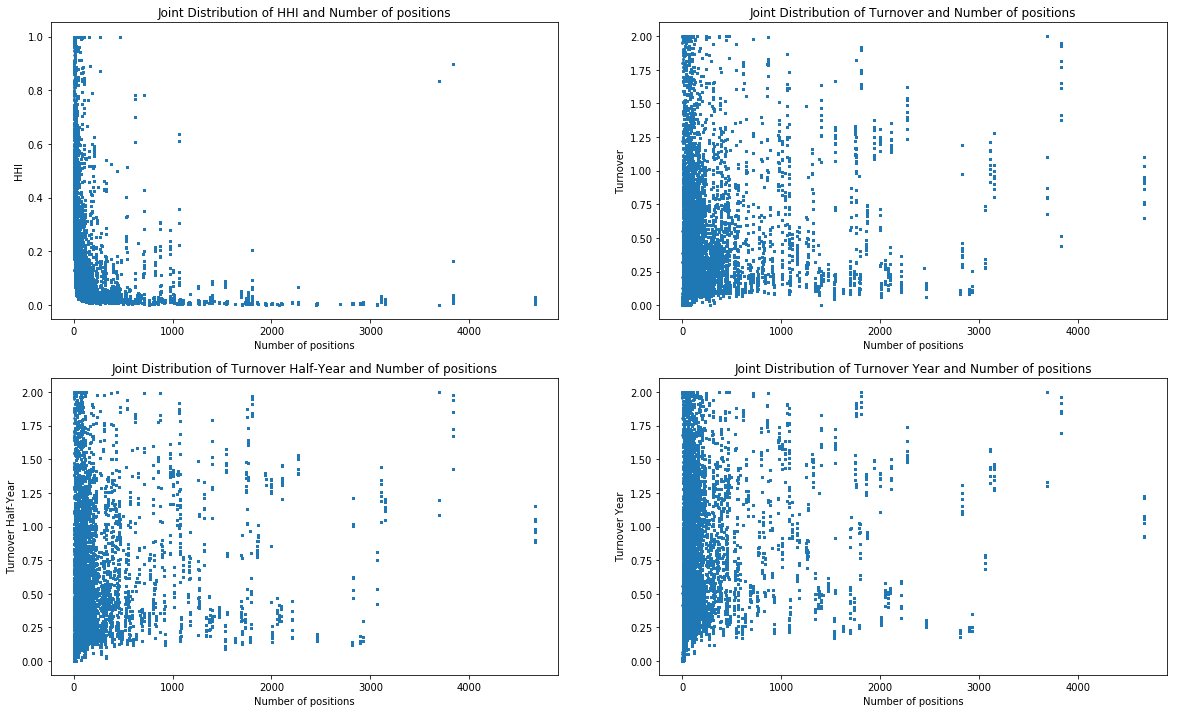

In [62] used -230.3750 MiB RAM in 76.06s, peaked 363.81 MiB above current, total RAM usage 744.89 MiB


In [62]:
fig, axs = pl.subplots(2, 2, figsize=(20, 12));

axs[0, 0].scatter(final_df.pos_count,
           final_df.hhi, s=1.8);
axs[0, 0].set_title('Joint Distribution of HHI and Number of positions');
axs[0, 0].set(xlabel='Number of positions', ylabel='HHI');

axs[0, 1].scatter(final_df.pos_count,
           final_df.turnover, s=1.8);
axs[0, 1].set_title('Joint Distribution of Turnover and Number of positions');
axs[0, 1].set(xlabel='Number of positions', ylabel='Turnover');

axs[1, 0].scatter(final_df.pos_count,
           final_df.turnover_halfyear, s=1.8);
axs[1, 0].set_title('Joint Distribution of Turnover Half-Year and Number of positions');
axs[1, 0].set(xlabel='Number of positions', ylabel='Turnover Half-Year');

axs[1, 1].scatter(final_df.pos_count,
           final_df.turnover_year, s=1.8);
axs[1, 1].set_title('Joint Distribution of Turnover Year and Number of positions');
axs[1, 1].set(xlabel='Number of positions', ylabel='Turnover Year');

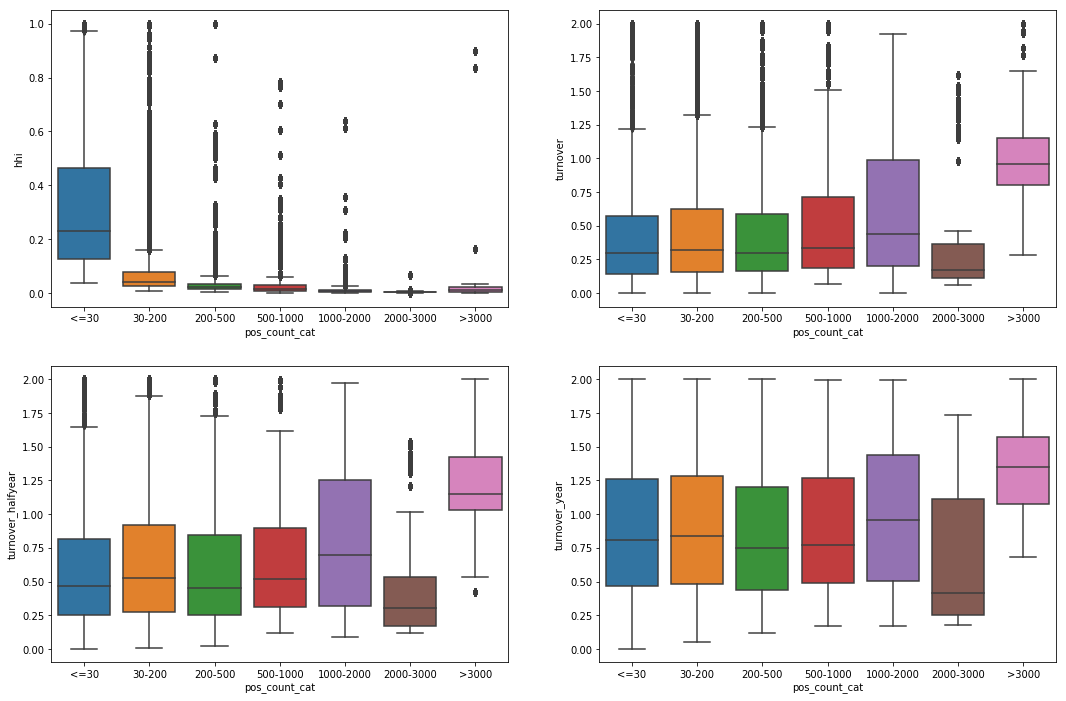

In [63] used -406.3477 MiB RAM in 5.98s, peaked 443.74 MiB above current, total RAM usage 338.54 MiB


In [63]:
fig, ax = pl.subplots(2, 2, figsize=(18, 12));
sns.boxplot(x='pos_count_cat', y='hhi', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='pos_count_cat', y='turnover', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='pos_count_cat', y='turnover_halfyear', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='pos_count_cat', y='turnover_year', data=final_df, ax=ax[1, 1]);

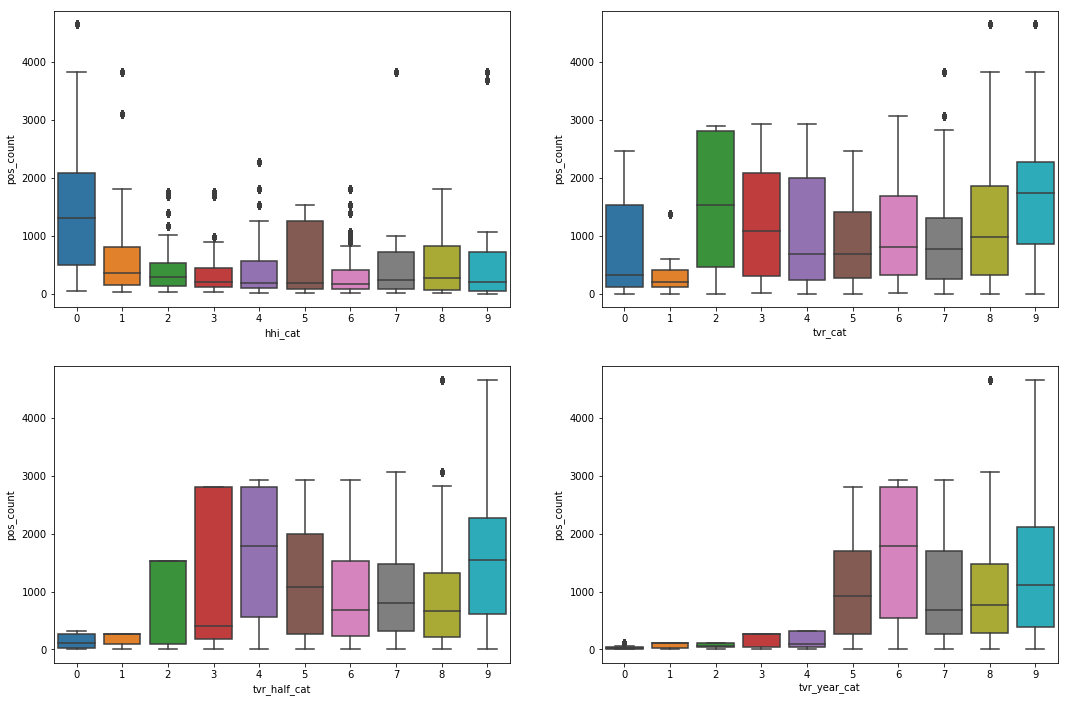

In [64] used 71.0000 MiB RAM in 2.82s, peaked 39.52 MiB above current, total RAM usage 409.54 MiB


In [64]:
fig, ax = pl.subplots(2, 2, figsize=(18, 12));
sns.boxplot(x='hhi_cat', y='pos_count', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='tvr_cat', y='pos_count', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='tvr_half_cat', y='pos_count', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='tvr_year_cat', y='pos_count', data=final_df, ax=ax[1, 1]);

Связь с зависимой переменной.

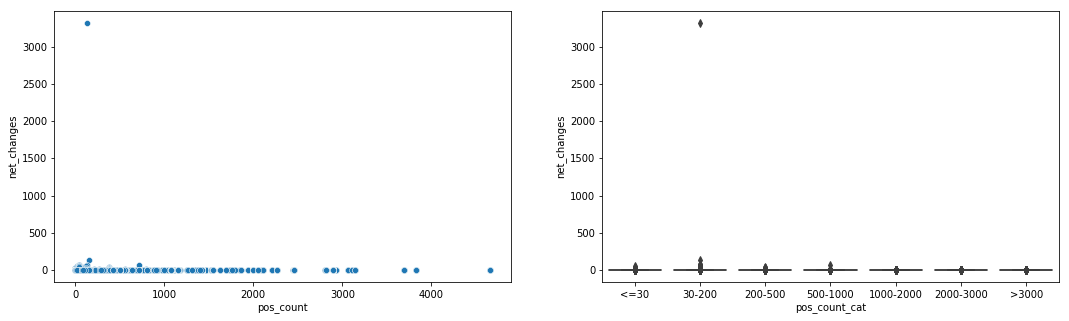

In [65] used 112.8750 MiB RAM in 26.76s, peaked 53.01 MiB above current, total RAM usage 522.42 MiB


In [65]:
fig, ax = pl.subplots(1,2, figsize=(18,5));
sns.scatterplot(x='pos_count', y='net_changes', data=final_df, ax=ax[0]);
sns.boxplot(x='pos_count_cat', y='net_changes', data=final_df, ax=ax[1]);

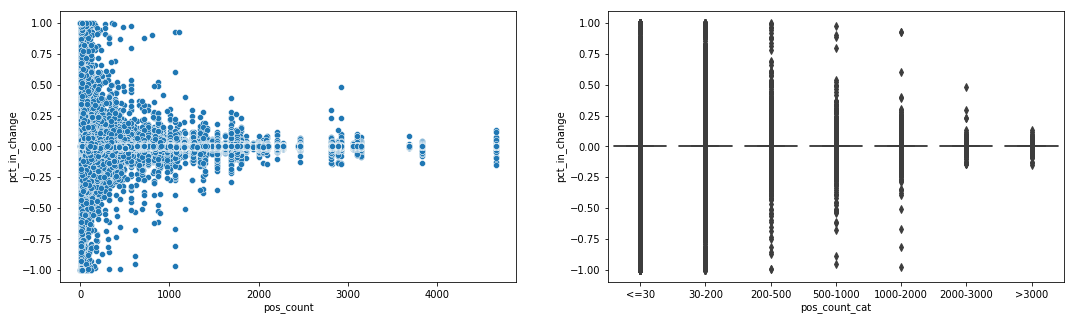

In [66] used 104.5039 MiB RAM in 28.03s, peaked 69.59 MiB above current, total RAM usage 626.92 MiB


In [66]:
fig, ax = pl.subplots(1,2, figsize=(18,5));
sns.scatterplot(x='pos_count', y='pct_in_change', data=final_df, ax=ax[0]);
sns.boxplot(x='pos_count_cat', y='pct_in_change', data=final_df, ax=ax[1]);

Корреляция переменных, связанных с фондами.

In [67]:
corr = final_df[['log_value_fund', 'value_cat', 'net_changes_abs_sum', 'turnover', 'turnover_halfyear', 'turnover_year',
'hhi', 'hhi_cat', 'tvr_cat', 'tvr_half_cat', 'tvr_year_cat',
'pos_count', 'pos_count_cat']].corr('spearman', min_periods=0)
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,log_value_fund,net_changes_abs_sum,turnover,turnover_halfyear,turnover_year,hhi,pos_count
log_value_fund,1.00,-0.11,-0.15,-0.18,-0.22,-0.50,0.58
net_changes_abs_sum,-0.11,1.00,0.95,0.87,0.81,0.02,0.18
turnover,-0.15,0.95,1.00,0.92,0.85,0.08,0.16
turnover_halfyear,-0.18,0.87,0.92,1.00,0.92,0.11,0.14
turnover_year,-0.22,0.81,0.85,0.92,1.00,0.16,0.08
hhi,-0.50,0.02,0.08,0.11,0.16,1.00,-0.64
pos_count,0.58,0.18,0.16,0.14,0.08,-0.64,1.00


In [67] used 715.8438 MiB RAM in 29.75s, peaked 595.43 MiB above current, total RAM usage 1342.77 MiB


Добавление средних изменений зависимых переменных.

In [68]:
%%time

# Составляю таблицы средних изменений позиций по тикеру, периоду и фонду

mean_pct_in_change = final_df.groupby(['ticker_id', 'period'])['pct_in_change'].mean().reset_index()
mean_pct_in_change.rename(columns={'pct_in_change': 'mean_pct_in_change'}, inplace=True)

mean_pct_in_change_by_cik = final_df.groupby(['cik', 'period'])['pct_in_change'].mean().reset_index()
mean_pct_in_change_by_cik.rename(columns={'pct_in_change': 'mean_pct_in_change_by_cik'}, inplace=True)

mean_pct_in_change_by_value = final_df.groupby(['ticker_id', 'period', 'value_cat']) \
                                                        ['pct_in_change'].mean().reset_index()
mean_pct_in_change_by_value.rename(columns={'pct_in_change': 'mean_pct_in_change_by_value'}, inplace=True)

mean_pct_in_change_by_pos_count = final_df.groupby(['ticker_id', 'period', 'pos_count_cat']) \
                                                        ['pct_in_change'].mean().reset_index()
mean_pct_in_change_by_pos_count.rename(columns={'pct_in_change': 'mean_pct_in_change_by_pos_count'}, inplace=True)



mean_net_changes = final_df.groupby(['ticker_id', 'period'])['net_changes'].mean().reset_index()
mean_net_changes.rename(columns={'net_changes': 'mean_net_changes'}, inplace=True)

mean_net_changes_by_cik = final_df.groupby(['cik', 'period'])['net_changes'].mean().reset_index()
mean_net_changes_by_cik.rename(columns={'net_changes': 'mean_net_changes_by_cik'}, inplace=True)

mean_net_changes_by_value = final_df.groupby(['ticker_id', 'period', 'value_cat']) \
                                                        ['net_changes'].mean().reset_index()
mean_net_changes_by_value.rename(columns={'net_changes': 'mean_net_changes_by_value'}, inplace=True)

mean_net_changes_by_pos_count = final_df.groupby(['ticker_id', 'period', 'pos_count_cat']) \
                                                        ['net_changes'].mean().reset_index()
mean_net_changes_by_pos_count.rename(columns={'net_changes': 'mean_net_changes_by_pos_count'}, inplace=True)

# Сцепляю их с нашим датасетом

final_df = final_df.merge(mean_pct_in_change, on=['ticker_id', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_pct_in_change_by_cik, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_pct_in_change_by_value, on=['ticker_id', 'period', 'value_cat'],
                                                                  how='left', suffixes=(False, False))
final_df = final_df.merge(mean_pct_in_change_by_pos_count, on=['ticker_id', 'period', 'pos_count_cat'],
                                                                  how='left', suffixes=(False, False))


final_df = final_df.merge(mean_net_changes, on=['ticker_id', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_net_changes_by_cik, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_net_changes_by_value, on=['ticker_id', 'period', 'value_cat'],
                                                                  how='left', suffixes=(False, False))
final_df = final_df.merge(mean_net_changes_by_pos_count, on=['ticker_id', 'period', 'pos_count_cat'],
                                                                  how='left', suffixes=(False, False))

# Считаю количество фондов, владеющих тикером в каждом периоде, чтобы вычесть потом долю отдельного фонда в среднем по тикеру

tickers_count = final_df.groupby(['ticker_id', 'period']).count().reset_index()
tickers_count_by_value = final_df.groupby(['ticker_id', 'period', 'value_cat'])\
                                                            .count().reset_index()
tickers_count_by_pos_count = final_df.groupby(['ticker_id', 'period', 'pos_count_cat'])\
                                                            .count().reset_index()

tickers_count.rename(columns={'shares': 'tickers_count'}, inplace=True)
tickers_count_by_value.rename(columns={'shares': 'tickers_count_by_value'}, inplace=True)
tickers_count_by_pos_count.rename(columns={'shares': 'tickers_count_by_pos_count'}, inplace=True)

final_df = final_df.merge(tickers_count[['ticker_id', 'period', 'tickers_count']], on=['ticker_id', 'period'],
                                                                                          how='left', suffixes=(False, False))

final_df = final_df.merge(tickers_count_by_value[['ticker_id', 'period', 'value_cat', 'tickers_count_by_value']], 
                                                                        on=['ticker_id', 'period', 'value_cat'],
                                                                                          how='left', suffixes=(False, False))
final_df = final_df.merge(tickers_count_by_pos_count[['ticker_id', 'period', 'pos_count_cat', 'tickers_count_by_pos_count']], 
                                                                        on=['ticker_id', 'period', 'pos_count_cat'],
                                                                                          how='left', suffixes=(False, False))

# Вычитаю из среднего по тикеру составляющую конкретного фонда в нем для каждого наблюдения
# Тем самым, я получаю среднее по всем остальным фондам

final_df['mean_pct_in_change'] -= final_df.pct_in_change.div(final_df.tickers_count, axis=0).values
final_df['mean_pct_in_change_by_cik'] -= final_df.pct_in_change.div(final_df.pos_count, axis=0).values
final_df['mean_pct_in_change_by_value'] -= final_df.pct_in_change.div(final_df.tickers_count_by_value, axis=0).values
final_df['mean_pct_in_change_by_pos_count'] -= final_df.pct_in_change.div(final_df.tickers_count_by_pos_count, axis=0).values

final_df['mean_net_changes'] -= final_df.net_changes.div(final_df.tickers_count, axis=0).values
final_df['mean_net_changes_by_cik'] -= final_df.net_changes.div(final_df.pos_count, axis=0).values
final_df['mean_net_changes_by_value'] -= final_df.net_changes.div(final_df.tickers_count_by_value, axis=0).values
final_df['mean_net_changes_by_pos_count'] -= final_df.net_changes.div(final_df.tickers_count_by_pos_count, axis=0).values

Wall time: 2min 17s
In [68] used 814.6680 MiB RAM in 137.99s, peaked 1917.29 MiB above current, total RAM usage 2157.43 MiB


In [69]:
from janitor import groupby_agg

ticker_value = final_df.groupby(['period', 'ticker_id'])['market_value'].sum().reset_index()
ticker_value.rename(columns={'market_value': 'market_value_ticker'}, inplace=True)
ticker_value = ticker_value.groupby_agg(
    by='period',
    agg='sum',
    agg_column_name='market_value_ticker',
    new_column_name='tickers_total_value'
)

ticker_value['ticker_market_share'] = ticker_value.market_value_ticker.div(ticker_value.tickers_total_value.add(1e-20), axis=0)

final_df = final_df.merge(ticker_value, on=['period', 'ticker_id'], how='left', suffixes=(None, None))
final_df['bench_dev'] =  (final_df.ticker_share - final_df.ticker_market_share).abs() / 2
final_df['active_share'] = final_df.groupby(['period', 'cik']).bench_dev.transform('sum')
final_df['log_market_value_ticker'] = np.log(final_df.market_value_ticker.add(1e-20))

ticker_value.head(10)

,period,ticker_id,market_value_ticker,tickers_total_value,ticker_market_share
0,2016Q1,779,64527808.0,7.050266e+11,9.152536e-05
1,2016Q1,780,25090728.0,7.050266e+11,3.558834e-05
2,2016Q1,784,26621000.0,7.050266e+11,3.775886e-05
3,2016Q1,829,93282000.0,7.050266e+11,1.323099e-04
4,2016Q1,835,27639079.0,7.050266e+11,3.920289e-05
5,2016Q1,838,89000.0,7.050266e+11,1.262364e-07
6,2016Q1,850,0.0,7.050266e+11,0.000000e+00
7,2016Q1,872,196309000.0,7.050266e+11,2.784420e-04
8,2016Q1,902,38370910.0,7.050266e+11,5.442477e-05
9,2016Q1,932,9940790.0,7.050266e+11,1.409988e-05


In [69] used 140.1133 MiB RAM in 4.82s, peaked 1115.18 MiB above current, total RAM usage 2297.55 MiB


<h2> Макро-индикаторы </h2>

Я предполагаю, что инвесторы обращают внимание на макроэкономическую ситуацию и её изменение <i>(иначе зачем макроэкономику преподают и изучают)</i>, чтобы исправлять свои стратегии.

<b> Поэтому я считаю, что важно проконтролировать изменение макроэкономических параметров в модели, так как без этого их влияние войдет в остаток, а я хочу, чтобы в остатках лежало только настроение фонда относительно тикера, определяемое его новыми инсайтами, а не экзогенными факторами. </b>

Я буду пользоваться парсером pandas, чтобы получать данные из статистической службы FRED.

В качестве переменных я собираюсь использовать поквартальное изменение ключевой ставки, ставки по десятилетним казначейским облигациям, уровню инфляции и росту ВВП (последние два тоже поквартальные).

In [70]:
import pandas_datareader as wb

In [70] used 1.9219 MiB RAM in 0.50s, peaked 0.00 MiB above current, total RAM usage 2299.47 MiB


In [71]:
# скачиваю ставки и нахожу их изменение, группируя по кварталам
rates = wb.DataReader(['DGS10', 'DFF', 'UNRATE'], 'fred', start=2012).resample('Q-DEC').mean().diff() / 100
rates.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
rates.DATE = rates.DATE.dt.to_period('Q')

In [71] used 8.2852 MiB RAM in 7.22s, peaked 0.00 MiB above current, total RAM usage 2307.75 MiB


In [72]:
# Нахожу инфлцяцию через Индекс потребительских цен, группируя по кварталам
inflation = wb.DataReader('CPIAUCSL', 'fred', start=2012).resample('Q-DEC').mean().pct_change()
inflation.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
inflation.DATE = inflation.DATE.dt.to_period('Q')

In [72] used 0.3203 MiB RAM in 0.34s, peaked 0.00 MiB above current, total RAM usage 2308.07 MiB


In [73]:
# Скачиваю данные по ВВП и считаю рост (а тут сразу всё поквартально!)
gdp_growth = wb.DataReader('GDP', 'fred', start=2012).pct_change()
gdp_growth.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
gdp_growth.DATE = gdp_growth.DATE.dt.to_period('Q')

In [73] used 0.0859 MiB RAM in 0.33s, peaked 0.00 MiB above current, total RAM usage 2308.16 MiB


In [74]:
%%time

# Связываю полученные значения с нашим датасетом

final_df = final_df.merge(rates, left_on='period', right_on='DATE', how='left', suffixes=(False, False))
final_df = final_df.merge(inflation, on="DATE", how='left', suffixes=(False, False))
final_df = final_df.merge(gdp_growth, on="DATE", how='left', suffixes=(False, False))
final_df.drop('DATE', axis=1, inplace=True)

Wall time: 12.5 s
In [74] used -502.9023 MiB RAM in 12.68s, peaked 2479.92 MiB above current, total RAM usage 1805.26 MiB


## Формирование датасетов для отдельных задач

Так как у многих активов в фондах может не хватать старших лагов, а также учитывая, что фонды не всегда вкладываются на долгий срок, то я для каждого количества доступных лагов, идущих подряд, начиная с первого, создам отдельный датасет, на котором я буду проводить отдельные испытания моделей. В итоге, у меня будет 4 датасета, в первом будут значения для первого лага, во втором - для первого и второго, и так далее.

Также, я создам 5-й датасет, где не будет ни одного лага, и я на нем буду решать задачу предсказания появления позиции по акции в фонде.

Кроме того, я хочу создать датасет, который бы помогал решить задачу определения ситуаций, когда фонд выходит из тикера, но создание такого датасета представляется чересчур ресурсозатратным, так как мой датасет знает только ситуации, когда фонд владел акциями. Плюс, я не всегда знаю, была ли в обороте та или иная акция в определенный квартал, которая не была ни в одном фонде в тот квартал, но есть в датасете.

In [75]:
%%time

final_df.drop(['access_id', 'conformed_submission_type', 'stamp', 'nid', 'ym_stamp', 'mode_close',
               'hhi_cat',  'value_cat', 'tvr_cat', 'tvr_half_cat', 'tvr_year_cat', 'pos_count_cat'], axis=1, inplace=True)

final_df = final_df.dropna(subset=['net_changes', 'pct_in_change', 'turnover', 'turnover_halfyear', 'turnover_year']).fillna(0)

final_df['enter'] = final_df.shares_lag_1.eq(0) & final_df.shares.ne(0)
final_df['exit'] = final_df.shares_lag_1.ne(0) & final_df.shares.eq(0)

Wall time: 3.62 s
In [75] used -608.1445 MiB RAM in 3.78s, peaked 1945.96 MiB above current, total RAM usage 1197.11 MiB


# Совершаем простейшие регрессии (через МНК)

Теперь, когда я определился с переменными, попробую определить характер зависимости чистого изменения позиции от регрессоров. Для красоты представления буду пользоваться библиотекой <i>statsmodels<i/>.

### Модель 1

In [76]:
import statsmodels.api as sm

In [76] used 36.3594 MiB RAM in 1.18s, peaked 0.00 MiB above current, total RAM usage 1233.47 MiB


In [77]:
data_common = final_df[~final_df.exit & ~final_df.enter]

In [77] used 571.5664 MiB RAM in 0.82s, peaked 0.00 MiB above current, total RAM usage 1805.04 MiB


In [78]:
y = data_common['pct_in_change']

X = data_common[['log_value_fund',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4', 'ticker_share',
       'pct_in_change_1', 'pct_in_change_2', 'pct_in_change_3', 'pct_in_change_4',
       'turnover', 'turnover_halfyear', 'turnover_year',
       'hhi', 'hhi_eq_1', 'pos_count',
       'mean_pct_in_change', 'mean_pct_in_change_by_cik',
       'mean_pct_in_change_by_value', 'mean_pct_in_change_by_pos_count', 'tickers_count',
       'tickers_count_by_value', 'log_market_value_ticker',
       'ticker_market_share', 'bench_dev', 'active_share']].astype('float64')
X = sm.add_constant(X)

In [78] used 226.6289 MiB RAM in 1.06s, peaked 518.15 MiB above current, total RAM usage 2031.67 MiB


Делаю первую модель. Простой метод наименьших квадратов.

In [79]:
model_1 = sm.OLS(y, X).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pct_in_change   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     889.3
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        00:30:25   Log-Likelihood:             2.8501e+06
No. Observations:             1089140   AIC:                        -5.700e+06
Df Residuals:                 1089113   BIC:                        -5.700e+06
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.0006      0.000      2.235      0.025    7.24e-05       0.001
log_value_fund                  -4.978e-05   1.27e-05     -3.924      0.000   -7.46e-05   -2.49e-05
diff_value_fund_rank_lag_1          0.0011   6.38e-05     17.051      0.000       0.001       0.001
diff_value_fund_rank_lag_2       8.817e-05   6.23e-05      1.415      0.157    -3.4e-05       0.000
diff_value_fund_rank_lag_3        6.17e-05   6.27e-05      0.984      0.325   -6.12e-05       0.000
diff_value_fund_rank_lag_4       4.826e-05   6.58e-05      0.734      0.463   -8.06e-05       0.000
ticker_share                       -0.0795      0.010     -8.349      0.000      -0.098      -0.061
pct_in_change_1                     0.0769      0.001    108.668      0.000       0.075       0.078
pct_in_change_2                     0.0316      0.001     45.545      0.000       0.030       0.033
pct_in_change_3                     0.0134      0.001     19.615      0.000       0.012       0.015
pct_in_change_4                     0.0297      0.001     39.729      0.000       0.028       0.031
turnover                        -7.867e-05   8.84e-05     -0.890      0.373      -0.000    9.46e-05
turnover_halfyear                   0.0002      0.000      2.143      0.032    1.86e-05       0.000
turnover_year                   -1.136e-05   7.75e-05     -0.147      0.883      -0.000       0.000
hhi                                -0.0009      0.000     -4.385      0.000      -0.001      -0.000
hhi_eq_1                            0.0197      0.001     24.606      0.000       0.018       0.021
pos_count                        -2.36e-08   2.09e-08     -1.132      0.258   -6.45e-08    1.73e-08
mean_pct_in_change                  0.0365      0.004      8.479      0.000       0.028       0.045
mean_pct_in_change_by_cik           0.1531      0.003     55.422      0.000       0.148       0.159
mean_pct_in_change_by_value         0.0375      0.002     16.321      0.000       0.033       0.042
mean_pct_in_change_by_pos_count     0.0726      0.002     29.952      0.000       0.068       0.077
tickers_count                     5.06e-07    4.8e-07      1.055      0.291   -4.34e-07    1.45e-06
tickers_count_by_value          -4.348e-06   3.42e-06     -1.272      0.203    -1.1e-05    2.35e-06
log_market_value_ticker         -1.231e-05   2.78e-06     -4.428      0.000   -1.78e-05   -6.86e-06
ticker_market_share                -0.0198      0.013     -1.468      0.142      -0.046       0.007
bench_dev                           0.1135      0.019      5.889      0.000       0.076       0.151
active_share                     1.706e-05      0.000      0.100      0.920      -0.000       0.000
==============================================================================
Omni

In [79] used 249.8359 MiB RAM in 5.63s, peaked 438.39 MiB above current, total RAM usage 2281.50 MiB


<b>MemoryError, когда хочу использовать матрицу робастных стандартных ошибок.

В результатах написано, что присутствует сильная мультиколлинеарность, но она нас не волнует, так как не влияет на состоятельность оценок.

Создаю меру настроя инвесторов. То, ради чего затевалась курсовая.

In [80]:
# Наша искомая переменная!
delta_1 = y - model_1.predict(X)

In [80] used 8.4375 MiB RAM in 0.21s, peaked 0.95 MiB above current, total RAM usage 2289.94 MiB


Посмотрим на её зависимость от величины активов. Предполагается, что будет наблюдаться некоторая зависимость.

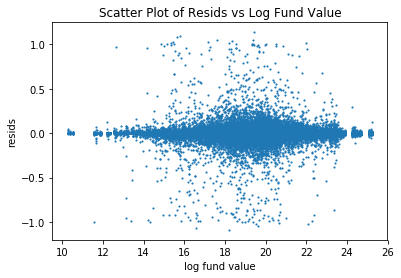

In [81] used 25.8438 MiB RAM in 12.64s, peaked 0.00 MiB above current, total RAM usage 2315.79 MiB


In [81]:
pl.scatter(X.log_value_fund, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs Log Fund Value');
pl.xlabel('log fund value');
pl.ylabel('resids');

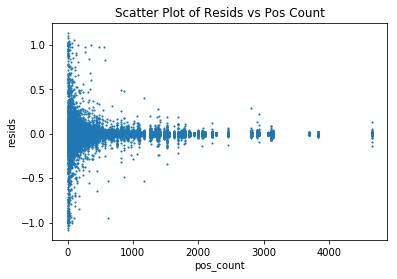

In [82] used 18.1016 MiB RAM in 10.50s, peaked 1.12 MiB above current, total RAM usage 2333.89 MiB


In [82]:
pl.scatter(X.pos_count, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs Pos Count');
pl.xlabel('pos_count');
pl.ylabel('resids');

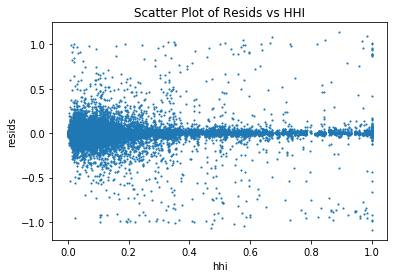

In [83] used -76.9883 MiB RAM in 12.51s, peaked 94.17 MiB above current, total RAM usage 2256.90 MiB


In [83]:
pl.scatter(X.hhi, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs HHI');
pl.xlabel('hhi');
pl.ylabel('resids');

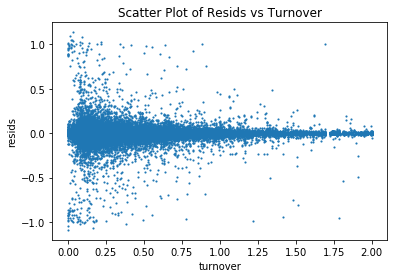

In [84] used 17.8203 MiB RAM in 9.29s, peaked 0.00 MiB above current, total RAM usage 2274.72 MiB


In [84]:
pl.scatter(X.turnover, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs Turnover');
pl.xlabel('turnover');
pl.ylabel('resids');

Ну это странно.

На графике видно, что остатки какие-то выдающиеся. Посмотрю на гистограмме, есть ли у меня такие наблюдения.

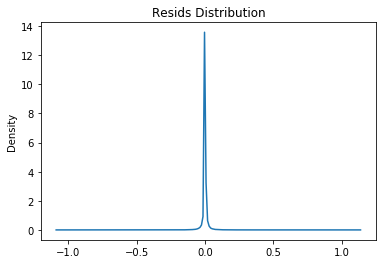

In [85] used 2.6406 MiB RAM in 21.33s, peaked 98.65 MiB above current, total RAM usage 2277.36 MiB


In [85]:
sns.kdeplot(delta_1).set_title("Resids Distribution");

Ну норм.

### Модель 2

In [86]:
y = data_common['pct_in_change']

X = data_common[['log_value_fund',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4', 'ticker_share',
       'pct_in_change_1', 'pct_in_change_2', 'pct_in_change_3', 'pct_in_change_4',
       'turnover', 'turnover_halfyear', 'turnover_year',
       'hhi', 'hhi_eq_1', 'pos_count',
       'mean_pct_in_change', 'mean_pct_in_change_by_cik',
       'mean_pct_in_change_by_value', 'mean_pct_in_change_by_pos_count', 'tickers_count',
       'tickers_count_by_value', 'log_market_value_ticker',
       'ticker_market_share', 'bench_dev', 'active_share',
        'DGS10', 'DFF', 'UNRATE',
        'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [86] used 265.9727 MiB RAM in 1.30s, peaked 649.10 MiB above current, total RAM usage 2543.33 MiB


In [87]:
model_2 = sm.OLS(y, X).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pct_in_change   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     747.1
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        00:31:39   Log-Likelihood:             2.8501e+06
No. Observations:             1089140   AIC:                        -5.700e+06
Df Residuals:                 1089108   BIC:                        -5.700e+06
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.0020      0.000      4.243      0.000       0.001       0.003
log_value_fund                  -5.298e-05   1.27e-05     -4.172      0.000   -7.79e-05   -2.81e-05
diff_value_fund_rank_lag_1          0.0012    6.5e-05     17.917      0.000       0.001       0.001
diff_value_fund_rank_lag_2       7.809e-05   6.32e-05      1.236      0.216   -4.57e-05       0.000
diff_value_fund_rank_lag_3       2.064e-05   6.33e-05      0.326      0.744      -0.000       0.000
diff_value_fund_rank_lag_4       5.591e-05   6.59e-05      0.849      0.396   -7.32e-05       0.000
ticker_share                       -0.0795      0.010     -8.345      0.000      -0.098      -0.061
pct_in_change_1                     0.0769      0.001    108.662      0.000       0.075       0.078
pct_in_change_2                     0.0317      0.001     45.576      0.000       0.030       0.033
pct_in_change_3                     0.0134      0.001     19.600      0.000       0.012       0.015
pct_in_change_4                     0.0297      0.001     39.730      0.000       0.028       0.031
turnover                           -0.0001   8.87e-05     -1.189      0.234      -0.000    6.83e-05
turnover_halfyear                   0.0002      0.000      2.276      0.023    3.23e-05       0.000
turnover_year                   -1.027e-05   7.76e-05     -0.132      0.895      -0.000       0.000
hhi                                -0.0009      0.000     -4.569      0.000      -0.001      -0.001
hhi_eq_1                            0.0198      0.001     24.657      0.000       0.018       0.021
pos_count                       -1.993e-08   2.09e-08     -0.955      0.340   -6.08e-08     2.1e-08
mean_pct_in_change                  0.0363      0.004      8.431      0.000       0.028       0.045
mean_pct_in_change_by_cik           0.1526      0.003     55.209      0.000       0.147       0.158
mean_pct_in_change_by_value         0.0375      0.002     16.306      0.000       0.033       0.042
mean_pct_in_change_by_pos_count     0.0726      0.002     29.954      0.000       0.068       0.077
tickers_count                    4.972e-07    4.8e-07      1.036      0.300   -4.43e-07    1.44e-06
tickers_count_by_value          -4.391e-06   3.42e-06     -1.285      0.199   -1.11e-05    2.31e-06
log_market_value_ticker         -1.234e-05   2.78e-06     -4.438      0.000   -1.78e-05   -6.89e-06
ticker_market_share                -0.0194      0.013     -1.438      0.150      -0.046       0.007
bench_dev                           0.1135      0.019      5.886      0.000       0.076       0.151
active_share                     4.226e-05      0.000      0.249      0.804      -0.000       0.000
DGS10                               0.1823      0.041      4.397      0.000       0

In [87] used 279.4570 MiB RAM in 5.57s, peaked 527.76 MiB above current, total RAM usage 2822.79 MiB


(Тут старые объяснения)

Наблюдается отрицательная зависимость от безработицы, положительная от инфляции и отрицательная от роста ВВП.
Первая зависимость интиутивно понятно. Низкая безработица свидетельствует о росте экономики, который наблюдается последнее время, а во время роста увеличиваются вложения в финансовые активы. Если рост вызван увеличением предложения, то ещё более очевидно, что улучшение ситуации у эмитентов делает их более привлекательным.

Вторая и третья зависимость не так очевидна, но у меня есть объяснение. Увеличение инфляции и падение выпуска происходит при уменьшении совокупного предложения. Это говорит об ухудшении положении эмитентов. Тем не менее, стоит вспомнить про то, что бизнес-циклы неотъемлемая часть экономики. И в такой ситуации очевидно наблюдается спад. Мы знаем, как и все, что после спада наступает рост. А во время роста (см. абзац выше) увеличивается спрос на финансовые активы и, как следствие, цена на них. Значит, инвестор может купить акции сейчас дешевле и продать их во время бума подороже. Наверно, так можно объяснить эти коэффициенты.

Положительная зависимость от ключевой ставки объясняется тем, что увеличение ставки может быть представлено как контр-мера против перегревания экономики во время экономического бума, а поведение во время бума я уже описывал.

Если надо, то я могу воспользоваться IS-LM моделью, чтобы более подробно попытаться объяснить зависимость и логику.

Заметим, что несмотря на свою красоту эта модель, как и предыдущие, имеет маленький R^2, то есть, имеет маленькую предсказательную способность и мало объясняет дисперсию изменения.
Но мы уже видели, что дисперсия так рознится из-за проблемы с малыми фондами и проблемы масштаба.

Главное, что наша модель имеет <b>прикладной и экономический смысл</b>!

### Модель 3

In [88]:
y = data_common['net_changes']

X = data_common[['log_value_fund',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4', 'ticker_share',
       'net_changes_1', 'net_changes_2', 'net_changes_3', 'net_changes_4',
       'turnover', 'turnover_halfyear', 'turnover_year',
       'hhi', 'hhi_eq_1', 'pos_count', 'tickers_count',
       'mean_net_changes',
       'mean_net_changes_by_cik', 'mean_net_changes_by_value',
       'mean_net_changes_by_pos_count',
       'tickers_count_by_value', 'log_market_value_ticker', 'tickers_total_value',
       'ticker_market_share', 'bench_dev', 'active_share',
        'DGS10', 'DFF', 'UNRATE',
        'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [88] used 274.2539 MiB RAM in 1.60s, peaked 762.38 MiB above current, total RAM usage 3097.04 MiB


In [89]:
model_3 = sm.OLS(y, X).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            net_changes   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     37.95
Date:                Tue, 22 Dec 2020   Prob (F-statistic):          5.47e-184
Time:                        00:31:45   Log-Likelihood:             5.6897e+05
No. Observations:             1089140   AIC:                        -1.138e+06
Df Residuals:                 1089114   BIC:                        -1.138e+06
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.0021      0.003      0.703      0.482      -0.004       0.008
log_value_fund                -3.942e-05      0.000     -0.382      0.702      -0.000       0.000
diff_value_fund_rank_lag_1        0.0001      0.001      0.281      0.779      -0.001       0.001
diff_value_fund_rank_lag_2        0.0008      0.001      1.631      0.103      -0.000       0.002
diff_value_fund_rank_lag_3        0.0004      0.001      0.707      0.479      -0.001       0.001
diff_value_fund_rank_lag_4    -4.686e-05      0.001     -0.088      0.930      -0.001       0.001
ticker_share                      0.0297      0.006      4.711      0.000       0.017       0.042
net_changes_1                    -0.0001      0.001     -0.160      0.873      -0.002       0.001
net_changes_2                     0.0002      0.001      0.267      0.790      -0.001       0.002
net_changes_3                  9.343e-06      0.001      0.014      0.989      -0.001       0.001
net_changes_4                    -0.0001      0.001     -0.176      0.861      -0.002       0.001
turnover                         -0.0002      0.001     -0.336      0.737      -0.002       0.001
turnover_halfyear                -0.0005      0.001     -0.586      0.558      -0.002       0.001
turnover_year                     0.0008      0.001      1.307      0.191      -0.000       0.002
hhi                              -0.0020      0.002     -1.214      0.225      -0.005       0.001
hhi_eq_1                         -0.0030      0.006     -0.466      0.641      -0.016       0.010
pos_count                     -6.669e-08   1.69e-07     -0.394      0.694   -3.99e-07    2.65e-07
tickers_count                  -4.12e-06   3.59e-06     -1.147      0.251   -1.12e-05    2.92e-06
mean_net_changes              -1.898e-05      0.000     -0.046      0.963      -0.001       0.001
mean_net_changes_by_cik           0.2219      0.007     29.985      0.000       0.207       0.236
mean_net_changes_by_value      3.429e-05      0.000      0.255      0.799      -0.000       0.000
mean_net_changes_by_pos_count  8.146e-06      0.000      0.053      0.958      -0.000       0.000
tickers_count_by_value         2.161e-05   2.77e-05      0.781      0.435   -3.26e-05    7.58e-05
log_market_value_ticker        7.869e-06   2.25e-05      0.350      0.726   -3.62e-05    5.19e-05
tickers_total_value           -1.546e-15   2.61e-15     -0.592      0.554   -6.67e-15    3.58e-15
ticker_market_share              -0.0068      0.019     -0.348      0.728      -0.045       0.031
bench_dev                         0.0113      0.008      1.462      0.144      -0.004       0.026
active_share                     -0.0001      0.001     -0.093      0.926      -0.003       0.003
DGS10                             0.0207     

In [89] used 40.2539 MiB RAM in 5.04s, peaked 1056.86 MiB above current, total RAM usage 3137.30 MiB


### Модель 4

In [90]:
y = final_df['enter']

X = final_df[['log_value_fund',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4',
       'pct_in_change_1', 'pct_in_change_2', 'pct_in_change_3', 'pct_in_change_4',
       'net_changes_1', 'net_changes_2', 'net_changes_3', 'net_changes_4',
       'turnover', 'turnover_halfyear', 'turnover_year',
       'hhi', 'hhi_eq_1', 'pos_count',
       'mean_pct_in_change', 'mean_pct_in_change_by_cik',
       'mean_pct_in_change_by_value', 'mean_pct_in_change_by_pos_count', 
       'mean_net_changes',
       'mean_net_changes_by_cik', 'mean_net_changes_by_value',
       'mean_net_changes_by_pos_count', 'tickers_count',
       'tickers_count_by_value', 'log_market_value_ticker',
       'ticker_market_share', 'bench_dev', 'active_share',
        'DGS10', 'DFF', 'UNRATE', 'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [90] used -990.0781 MiB RAM in 3.14s, peaked 1985.79 MiB above current, total RAM usage 2147.22 MiB


In [91]:
model_4 = sm.Logit(y, X).fit()
print(model_4.summary())

Optimization terminated successfully.
         Current function value: 0.262090
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                  enter   No. Observations:              1299695
Model:                          Logit   Df Residuals:                  1299656
Method:                           MLE   Df Model:                           38
Date:                Tue, 22 Dec 2020   Pseudo R-squ.:                 0.05488
Time:                        00:32:13   Log-Likelihood:            -3.4064e+05
converged:                       True   LL-Null:                   -3.6042e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -7.2387      0.097    -74.257 

### Модель 5

In [92]:
y = final_df['exit']

X = final_df[['log_value_fund',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4',
       'pct_in_change_1', 'pct_in_change_2', 'pct_in_change_3', 'pct_in_change_4',
       'net_changes_1', 'net_changes_2', 'net_changes_3', 'net_changes_4',
       'turnover', 'turnover_halfyear', 'turnover_year',
       'hhi', 'hhi_eq_1', 'pos_count',
       'mean_pct_in_change', 'mean_pct_in_change_by_cik',
       'mean_pct_in_change_by_value', 'mean_pct_in_change_by_pos_count', 
       'mean_net_changes',
       'mean_net_changes_by_cik', 'mean_net_changes_by_value',
       'mean_net_changes_by_pos_count', 'tickers_count',
       'tickers_count_by_value', 'log_market_value_ticker',
       'ticker_market_share', 'bench_dev', 'active_share',
        'DGS10', 'DFF', 'UNRATE', 'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [92] used 364.0625 MiB RAM in 2.10s, peaked 1107.22 MiB above current, total RAM usage 2525.05 MiB


In [93]:
model_5 = sm.Logit(y, X).fit()
print(model_5.summary())

Optimization terminated successfully.
         Current function value: 0.256569
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:                   exit   No. Observations:              1299695
Model:                          Logit   Df Residuals:                  1299656
Method:                           MLE   Df Model:                           38
Date:                Tue, 22 Dec 2020   Pseudo R-squ.:                 0.09999
Time:                        00:32:42   Log-Likelihood:            -3.3346e+05
converged:                       True   LL-Null:                   -3.7051e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -2.4636      0.086    -28.703 

# Сохранение датасета.

Для удобства сохраню полученные результаты.

In [94]:
import pickle

# сохраняю полный датасет
with open('final_df.pkl', 'wb') as f:
    pickle.dump(final_df, f, protocol=-1)

In [94] used 282.4570 MiB RAM in 8.70s, peaked 768.56 MiB above current, total RAM usage 2818.89 MiB


# Планируемая работа

4. Понять, надо ли оставлять в данных, на которых я буду тренировать бустинги, леса и прочие чудеса, кросс-произведения дохода и других непрерывных переменных или достаточно будет использовать все переменные по отдельности, ведь всех можно применить PolynomialFeatures.<br><br> (Разобрались)<br><br>

5. Понять, как лучше разделять данные на тест и трейн.<br><br> <b>(Непонятно)</b><br><br>

the coursework will return ...